Vamos a cargar el dataset de AirBnB

In [2]:
library(tidyverse)
library(conflicted)
##tuve problemas con las librerias
conflict_prefer("filter", "dplyr")
conflict_prefer("lag", "dplyr")
airbnb<-read.csv('airbnb-listings.csv',sep = ';')
options(repr.plot.height=4,repr.plot.width=6,repr.plot.res = 300)

[conflicted] Will prefer dplyr::filter over any other package.
[conflicted] Will prefer dplyr::lag over any other package.


Vamos a quedarnos con las columnas de mayor interés y convertimos de Square.Feet a Square.Meters (1 foot=0.092903m²):

In [3]:
df_airbnb<-airbnb[,c('City','Room.Type','Neighbourhood','Accommodates','Bathrooms','Bedrooms','Beds',
               'Price','Square.Feet',
                'Guests.Included','Extra.People',
               'Review.Scores.Rating','Latitude', 'Longitude')]
df_airbnb$Square.Meters<-df_airbnb$Square.Feet*0.092903

Nos quedarmos solo con las entradas de Madrid para Room.Type=="Entire home/apt" y cuyo barrio (Neighbourhood) no está vacio ''
Podemos eliminar las siguientes columnas que ya no son necesarias:
"Room.Type",'City'

Llama a nuevo dataframe df_madrid.

In [4]:
# Seleccionar solo las entradas de Madrid con Room.Type == "Entire home/apt" y barrio no vacío
df_madrid <- df_airbnb[df_airbnb$City == "Madrid" & df_airbnb$Room.Type == "Entire home/apt" & df_airbnb$Neighbourhood != "", ]

# Eliminar las columnas "Room.Type" y "City"
df_madrid <- df_madrid[, !colnames(df_madrid) %in% c("Room.Type", "City","Square.Feet")]

set.seed(123)

In [5]:
summary(df_madrid)

 Neighbourhood       Accommodates      Bathrooms        Bedrooms     
 Length:5601        Min.   : 1.000   Min.   :0.000   Min.   : 0.000  
 Class :character   1st Qu.: 3.000   1st Qu.:1.000   1st Qu.: 1.000  
 Mode  :character   Median : 4.000   Median :1.000   Median : 1.000  
                    Mean   : 4.101   Mean   :1.248   Mean   : 1.453  
                    3rd Qu.: 5.000   3rd Qu.:1.000   3rd Qu.: 2.000  
                    Max.   :16.000   Max.   :6.500   Max.   :10.000  
                                     NA's   :14      NA's   :7       
      Beds            Price        Guests.Included   Extra.People   
 Min.   : 1.000   Min.   : 10.00   Min.   : 1.000   Min.   :  0.00  
 1st Qu.: 1.000   1st Qu.: 56.00   1st Qu.: 1.000   1st Qu.:  0.00  
 Median : 2.000   Median : 75.00   Median : 2.000   Median : 10.00  
 Mean   : 2.393   Mean   : 88.74   Mean   : 1.952   Mean   :  8.79  
 3rd Qu.: 3.000   3rd Qu.:100.00   3rd Qu.: 2.000   3rd Qu.: 15.00  
 Max.   :16.000   Max.   :

¿Que porcentaje de los apartamentos no muestran los metros cuadrados? Es decir que tienen NA en Square.Meters

In [6]:
###Cociente entre los que son na y el numero total
paste0("El porcentaje de valores NAs es: ",round(sum(is.na(df_madrid$Square.Meters)/nrow(df_madrid))*100, 2),"%")

[1] "El porcentaje de valores NAs es: 93.8%"

De todos los apartamentos que tienen un valor de metros cuadrados diferente de NA 
¿Que porcentaje de los apartamentos tienen 0 metros cuadrados?

In [7]:
##Cociente entre los que son de 0 metros cuadrados y distintos de NAs
paste0("El porcentaje de ceros es: ",round(sum(df_madrid$Square.Meters==0,na.rm=T)/sum(!is.na(df_madrid$Square.Meters))*100,2),"%")

[1] "El porcentaje de ceros es: 36.89%"

Reemplazar todos los 0m^2 por NA 

In [8]:
df_madrid$Square.Meters[df_madrid$Square.Meters == 0] <- NA

Son muchos, vamos a intentar crear un modelo que nos prediga cuantos son los metros cuadrados en función del resto de variables para tratar de rellenar esos NA.

Antes de eso deberíamos pintar el histograma de los metros cuadrados y ver si tenemos que filtrar algún elemento más.

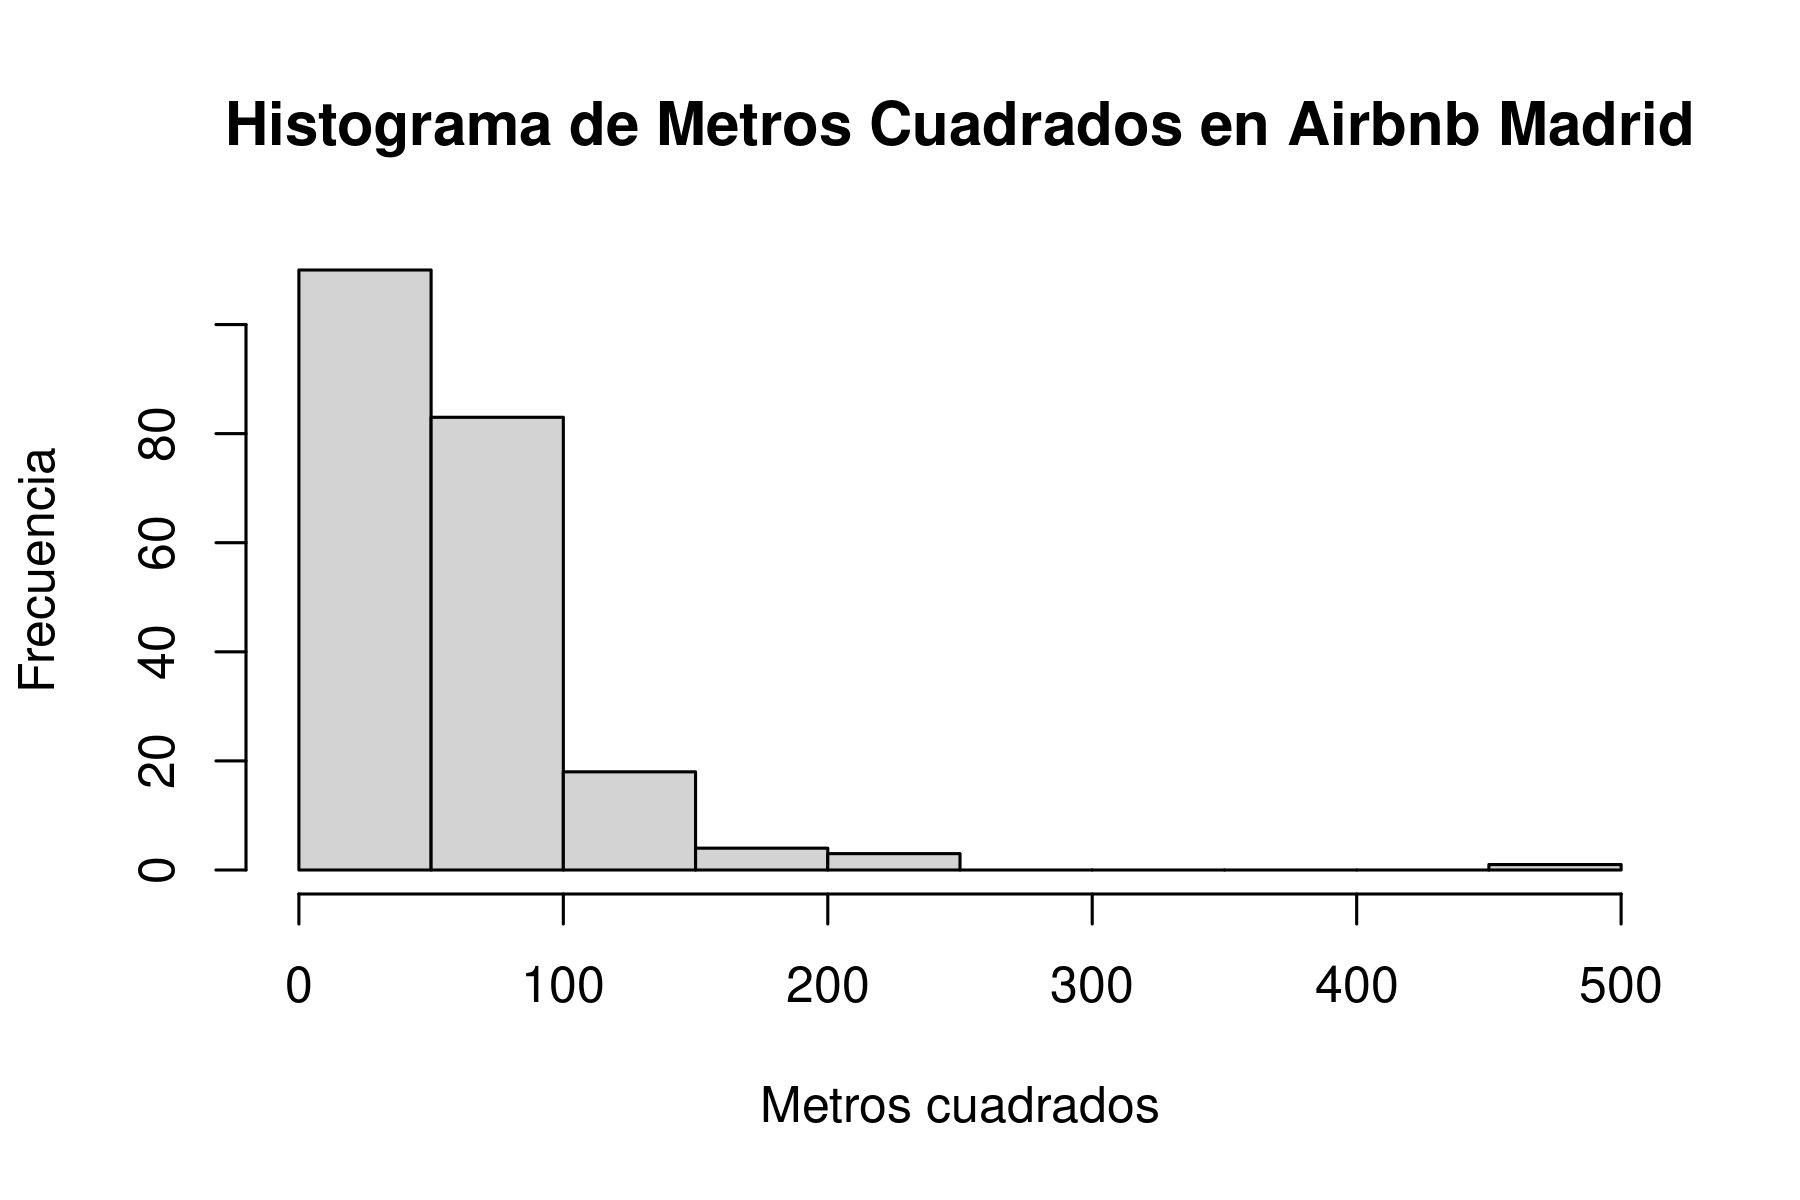

In [9]:
hist(df_madrid$Square.Meters, xlab = "Metros cuadrados", ylab = "Frecuencia", main = "Histograma de Metros Cuadrados en Airbnb Madrid")

In [10]:
df_madrid[which(df_madrid$Square.Meters<20),]

,Neighbourhood,Accommodates,Bathrooms,Bedrooms,Beds,Price,Guests.Included,Extra.People,Review.Scores.Rating,Latitude,Longitude,Square.Meters
,<chr>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
385,Cortes,6,2.0,2,1,108,2,11,86,40.41133,-3.695197,8.361270
389,Cortes,2,2.0,1,1,60,2,15,81,40.41403,-3.701206,3.994829
600,Sol,2,1.0,1,1,75,2,0,91,40.41917,-3.706242,6.596113
648,Argüelles,2,1.0,1,1,75,2,11,76,40.42503,-3.713599,3.251605
1088,Sol,6,2.0,2,3,90,1,0,100,40.41790,-3.708193,9.290300
1223,Embajadores,2,1.0,1,1,40,1,0,90,40.40860,-3.701873,19.974145
2065,Recoletos,2,1.0,1,1,60,1,0,96,40.42315,-3.682789,19.974145
2135,Palacio,5,1.0,1,1,75,2,10,47,40.41997,-3.708150,5.109665
2414,Palos do Moguer,2,1.0,1,2,66,2,11,96,40.40642,-3.695096,2.972896


In [11]:
df_madrid[which(df_madrid$Square.Meters<10),]

,Neighbourhood,Accommodates,Bathrooms,Bedrooms,Beds,Price,Guests.Included,Extra.People,Review.Scores.Rating,Latitude,Longitude,Square.Meters
,<chr>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
385,Cortes,6,2.0,2,1,108,2,11,86,40.41133,-3.695197,8.361270
389,Cortes,2,2.0,1,1,60,2,15,81,40.41403,-3.701206,3.994829
600,Sol,2,1.0,1,1,75,2,0,91,40.41917,-3.706242,6.596113
648,Argüelles,2,1.0,1,1,75,2,11,76,40.42503,-3.713599,3.251605
1088,Sol,6,2.0,2,3,90,1,0,100,40.41790,-3.708193,9.290300
2135,Palacio,5,1.0,1,1,75,2,10,47,40.41997,-3.708150,5.109665
2414,Palos do Moguer,2,1.0,1,2,66,2,11,96,40.40642,-3.695096,2.972896
2713,Malasaña,6,1.5,3,1,119,2,11,47,40.42395,-3.705095,6.967725
3114,Estrella,2,1.0,1,2,50,1,0,88,40.40940,-3.665227,2.043866


Asigna el valor NA a la columna Square.Meters de los apartamentos que tengan menos de 20 m^2

In [12]:
df_madrid$Square.Meters[df_madrid$Square.Meters < 20] <- NA

Existen varios Barrios que todas sus entradas son NA, vamos a eliminar del dataset todos los pisos que pertenecen a estos barrios.

In [13]:
# Obtener los nombres de los barrios donde todas las entradas son NA
na_neigh <- colnames(df_madrid)[colSums(is.na(df_madrid)) == nrow(df_madrid)]

# Mostrar los barrios encontrados
na_neigh

# Eliminar las filas correspondientes a los barrios donde todas las entradas son NA
df_madrid <- df_madrid[complete.cases(df_madrid[, !colnames(df_madrid) %in% na_neigh]), ]

#df_madrid <- df_madrid[!is.na(df_madrid$Square.Meters) | !duplicated(df_madrid$Neighbourhood), ]

character(0)

El barrio parece ser un indicador importante para los metros cuadrados de un apartamento.

Vamos a agrupar los barrios por metros cuadrados. Podemos usar una matriz de similaridad de Tukey tal y como hicimos en el curso de estadística:

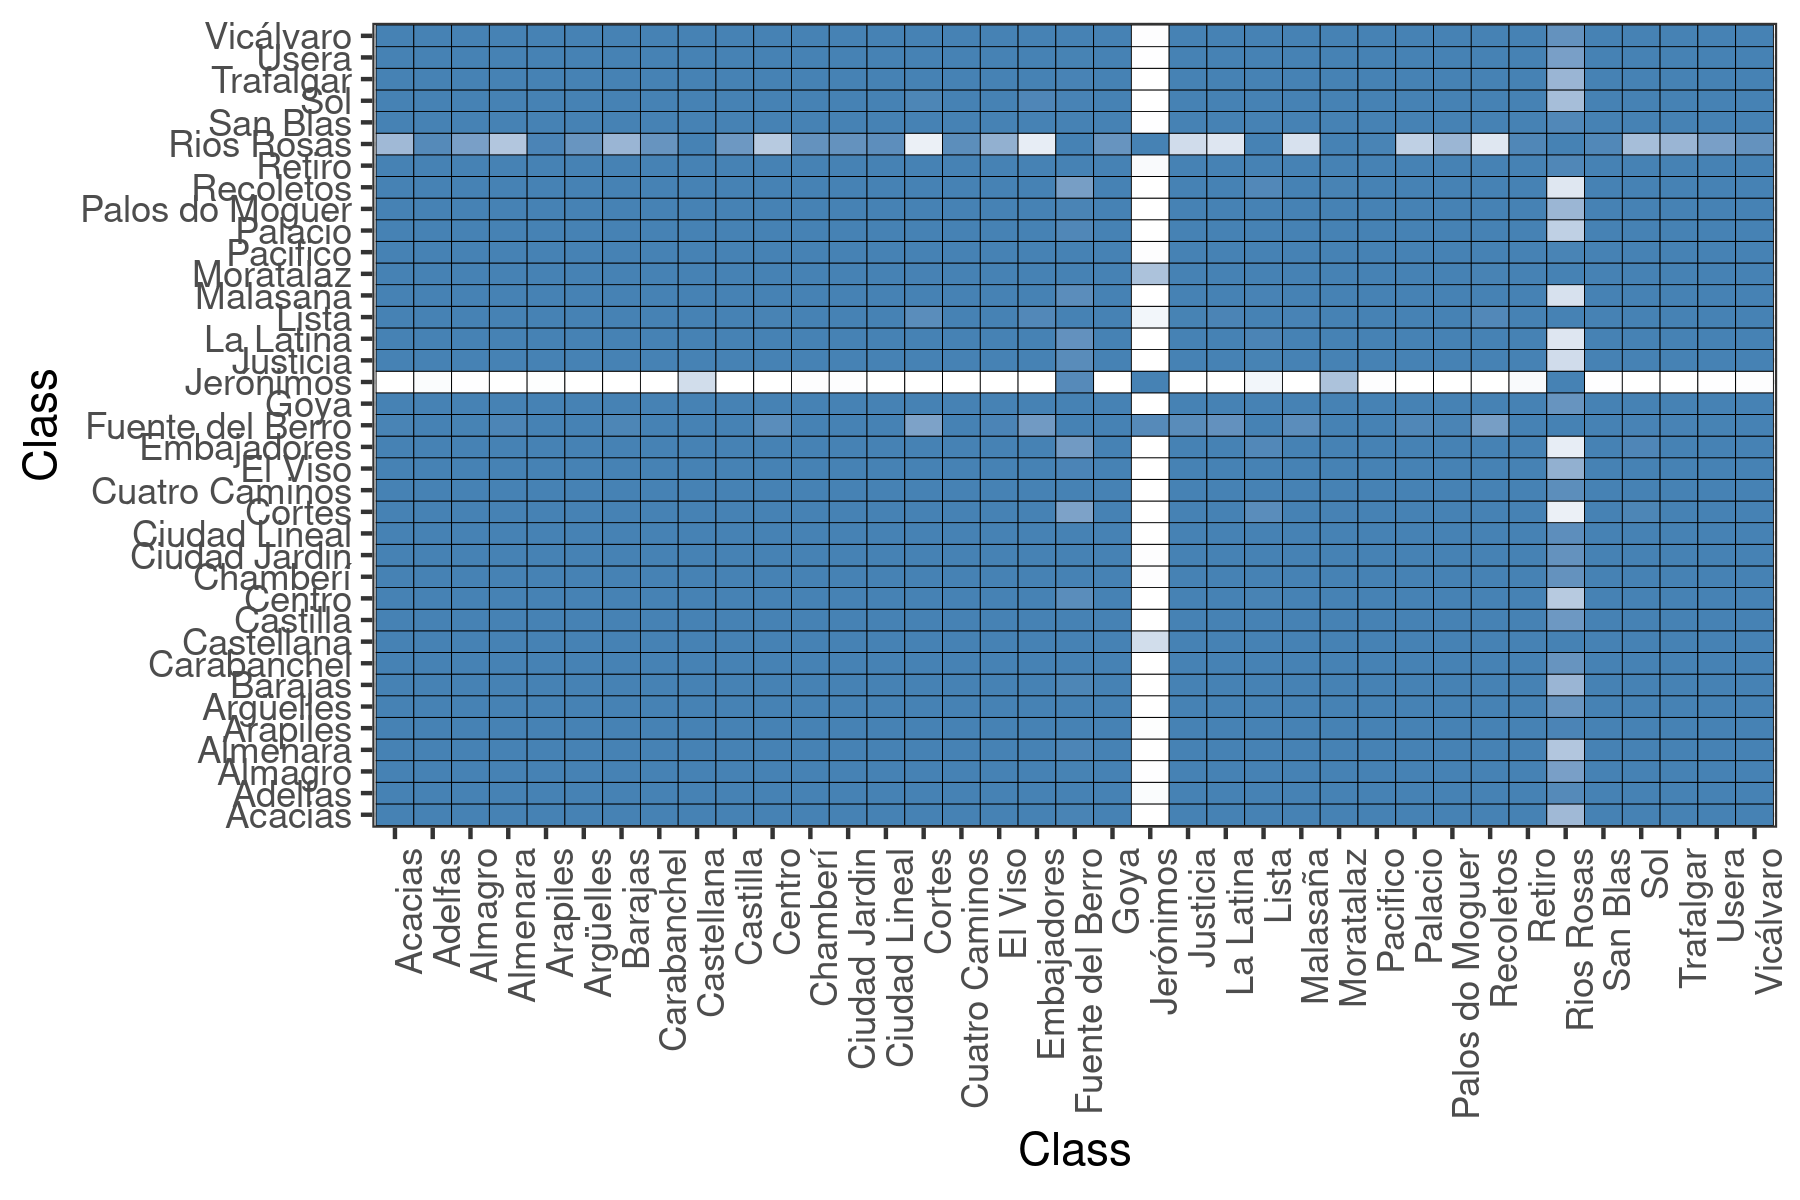

In [14]:
tky<-TukeyHSD(aov( formula=Square.Meters~Neighbourhood, data=df_madrid ))
tky.result<-data.frame(tky$Neighbourhood)
cn <-sort(unique(df_madrid$Neighbourhood))
resm <- matrix(NA, length(cn),length(cn))
rownames(resm) <- cn
colnames(resm) <- cn
resm[lower.tri(resm) ] <- round(tky.result$p.adj,4)
resm[upper.tri(resm) ] <- t(resm)[upper.tri(resm)] 
diag(resm) <- 1
library(ggplot2)
library(reshape2)
dfResm <- melt(resm)
ggplot(dfResm, aes(x=Var1, y=Var2, fill=value))+
  geom_tile(colour = "black")+
  scale_fill_gradient(low = "white",high = "steelblue")+
  ylab("Class")+xlab("Class")+theme_bw()+
  theme(axis.text.x = element_text(angle = 90, hjust = 1),legend.position="none")

Usando como variable de distancia: 1-resm
Dibuja un dendrograma de los diferentes barrios.


In [15]:
f_dist<-as.dist(1-resm)
hc <- hclust(f_dist,method="complete")
hcd <- as.dendrogram(hc)

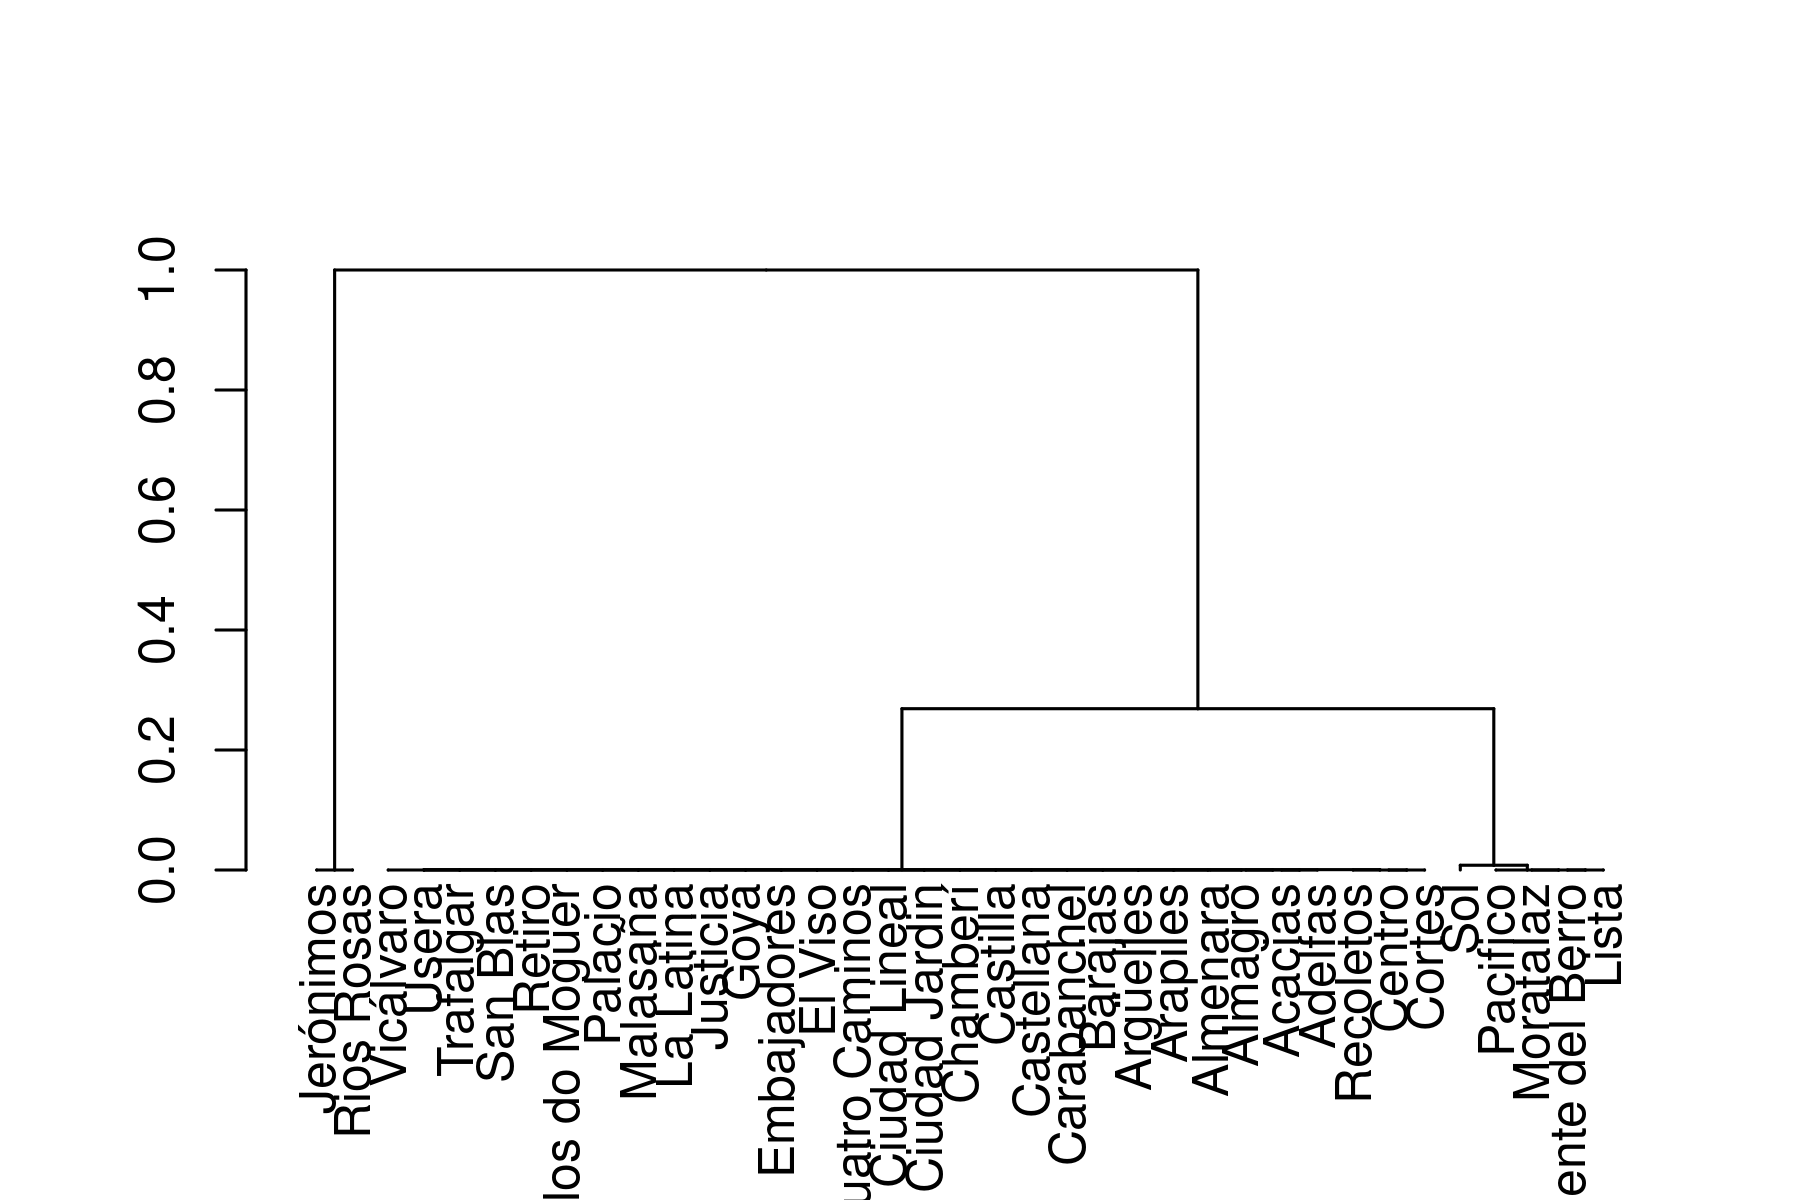

In [16]:
plot(hcd)

¿Que punto de corte sería el aconsejable?, ¿cuantos clusters aparecen?

In [17]:
## Viendo los clusteres y donde cortan parece que un buen corte seria en 0.2

ct<-cutree(hc,h=0.2)

Vamos a crear una nueva columna en el dataframe df_madrid con un nuevo identificador marcado por los clusters obtenidos. Esta columna la llamaremos neighb_id

In [19]:
df_barrios<-data.frame(names=names(ct),neighb_id=paste0("neighd_id_",ct))
head(df_barrios)

,names,neighb_id
,<chr>,<chr>
1,Acacias,neighd_id_1
2,Adelfas,neighd_id_1
3,Almagro,neighd_id_1
4,Almenara,neighd_id_1
5,Arapiles,neighd_id_1
6,Argüelles,neighd_id_1


In [21]:
df_madrid_id <- df_madrid %>% 
    inner_join(df_barrios,by=c("Neighbourhood"='names')) %>%
    filter(!is.na(Square.Meters))

dim(df_madrid_id) 
head(df_madrid_id)


## Aqui ya tuve que usar tidyverse no lo consegui con el siguiente codigo, no se porque no me salia
# Unir df_madrid y df_barrios
#df_madrid_id <- merge(df_madrid, df_barrios, by.x = "Neighbourhood", by.y = "names")
#head(df_madrid_id)

# Filtrar las filas donde Square.Meters no es NA
#df_madrid_id <- df_madrid[!is.na(df_madrid$Square.Meters), ]


[1] 165  13

,Neighbourhood,Accommodates,Bathrooms,Bedrooms,Beds,Price,Guests.Included,Extra.People,Review.Scores.Rating,Latitude,Longitude,Square.Meters,neighb_id
,<chr>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>
1,La Latina,6,2.0,2,2,72,2,20,90,40.41206,-3.709149,54.99858,neighd_id_1
2,Acacias,4,1.0,1,2,60,2,15,98,40.40513,-3.707726,49.98181,neighd_id_1
3,Malasaña,4,1.0,2,3,105,1,0,97,40.42900,-3.703498,69.95596,neighd_id_1
4,Recoletos,2,1.0,0,2,61,1,0,92,40.42800,-3.686409,30.00767,neighd_id_1
5,Malasaña,8,2.0,3,4,120,6,0,83,40.42198,-3.705419,109.99715,neighd_id_1
6,Argüelles,4,1.5,2,2,95,2,15,89,40.42920,-3.717775,96.99073,neighd_id_1


Vamos a crear dos grupos, uno test y otro train.

Tratamos de predecir los metros cuadrados.

In [22]:
##Creamos training y test set
set.seed(12)
idx<-sample(1:nrow(df_madrid_id),nrow(df_madrid_id)*0.8)
df_madrid_id_train<-df_madrid_id[idx,]
df_madrid_id_test<-df_madrid_id[-idx,]

In [25]:
##Generamos modelo
model<-lm(formula=Square.Meters~neighb_id+neighb_id+Price+Bedrooms, df_madrid_id_train)
summary(model)


Call:
lm(formula = Square.Meters ~ neighb_id + neighb_id + Price + 
    Bedrooms, data = df_madrid_id_train)

Residuals:
     Min       1Q   Median       3Q      Max 
-110.245  -14.117   -1.819   10.160  173.889 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)           15.63073    4.99627   3.128  0.00218 ** 
neighb_idneighd_id_2   8.48475    6.05915   1.400  0.16386    
neighb_idneighd_id_3 124.25949   17.43409   7.127 6.82e-11 ***
Price                  0.09712    0.03692   2.631  0.00958 ** 
Bedrooms              26.16043    2.98920   8.752 1.10e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 28.15 on 127 degrees of freedom
Multiple R-squared:  0.6738,	Adjusted R-squared:  0.6636 
F-statistic: 65.59 on 4 and 127 DF,  p-value: < 2.2e-16


In [27]:
print("Comprobamos en el R² y otras medidas en train y test para ver si tenemos overfitting:")
caret::postResample(predict(model,df_madrid_id_train),obs = df_madrid_id_train$Square.Meters)
caret::postResample(predict(model,df_madrid_id_test),obs = df_madrid_id_test$Square.Meters)

[1] "Comprobamos en el R² y otras medidas en train y test para ver si tenemos overfitting:"


RMSE   Rsquared        MAE 
27.6070397  0.6738243 17.8530688

RMSE   Rsquared        MAE 
20.6392729  0.6890732 16.0453683

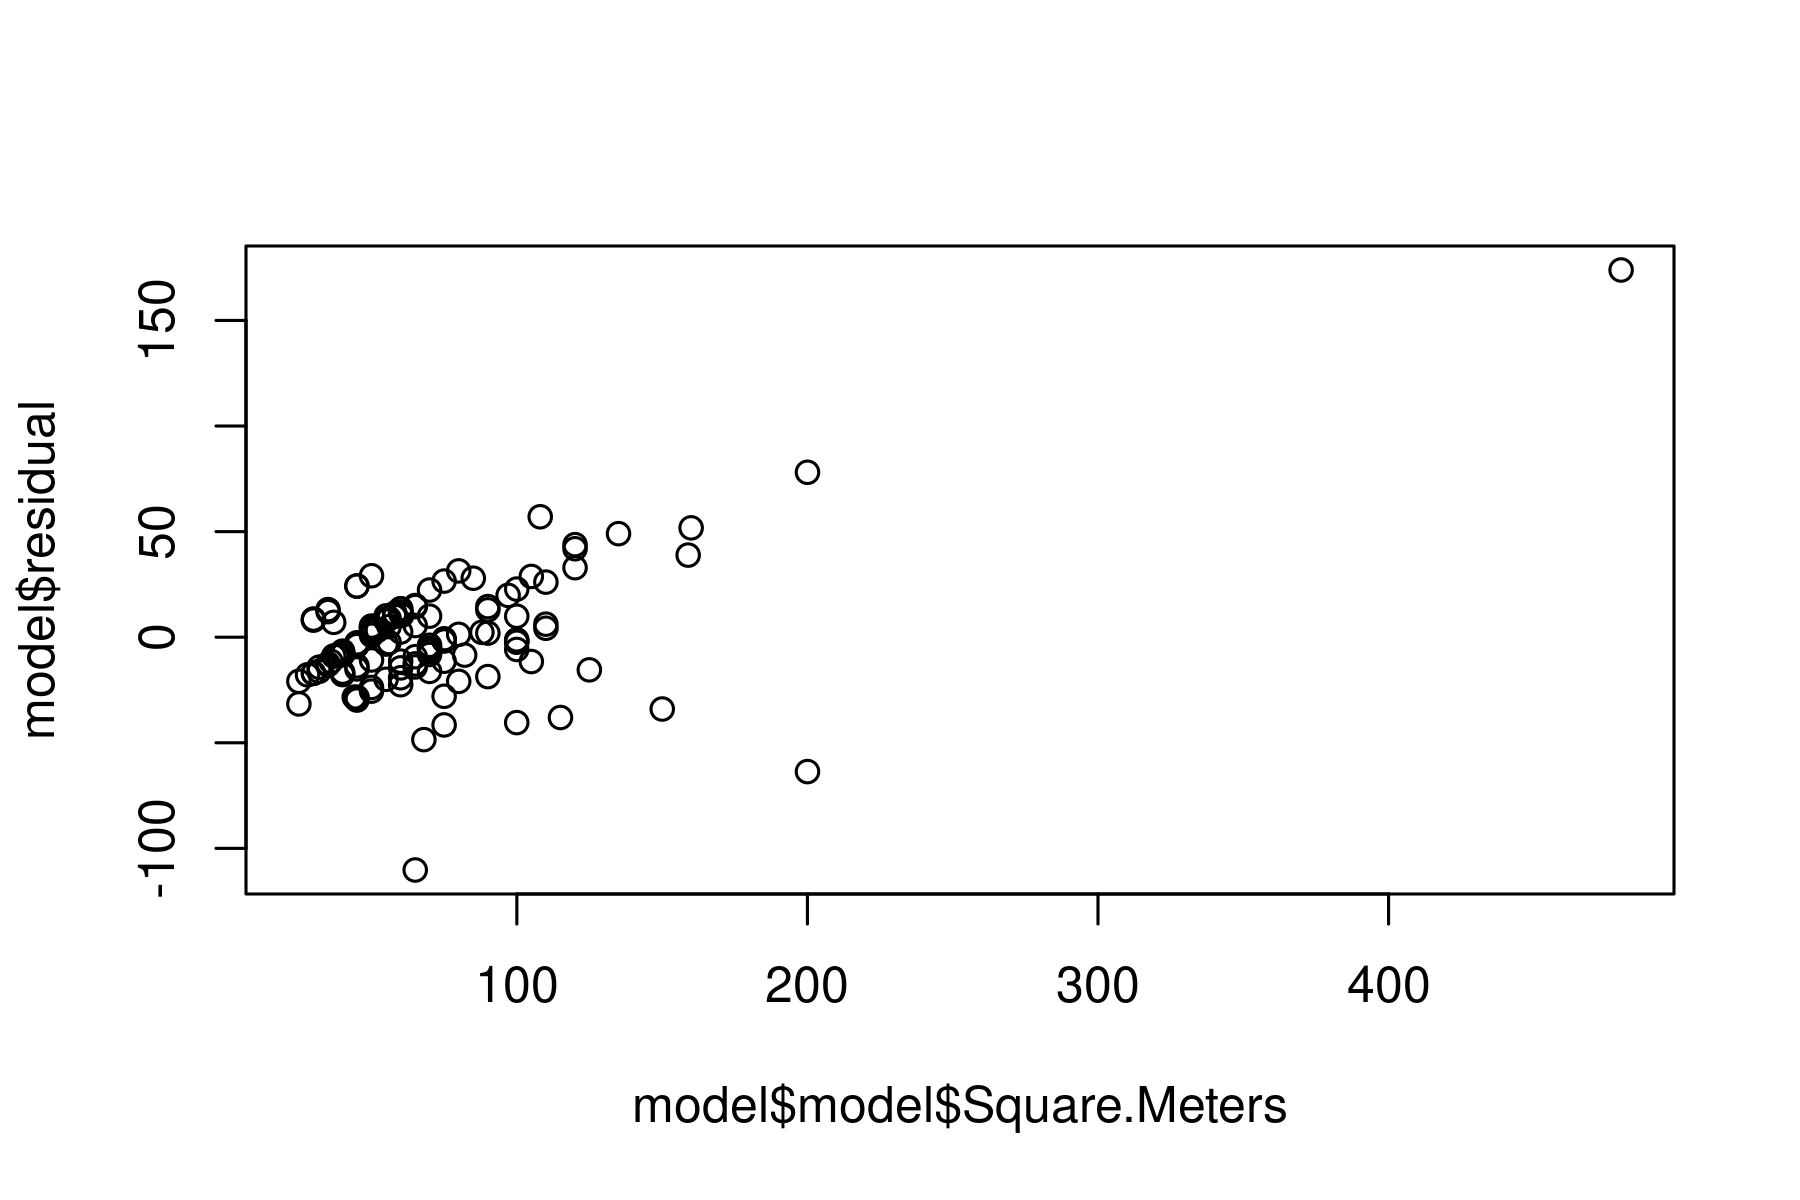

In [29]:
plot(model$model$Square.Meters,model$residual)

## Del grafico observamos:
## un outlier en los datos, que quizás deberíamos tratar. 
## En cuanto a la heterocedasticidad, parece que la varianza está aumentando un poco,
## pero no hay motivos de preocupación en este momento.

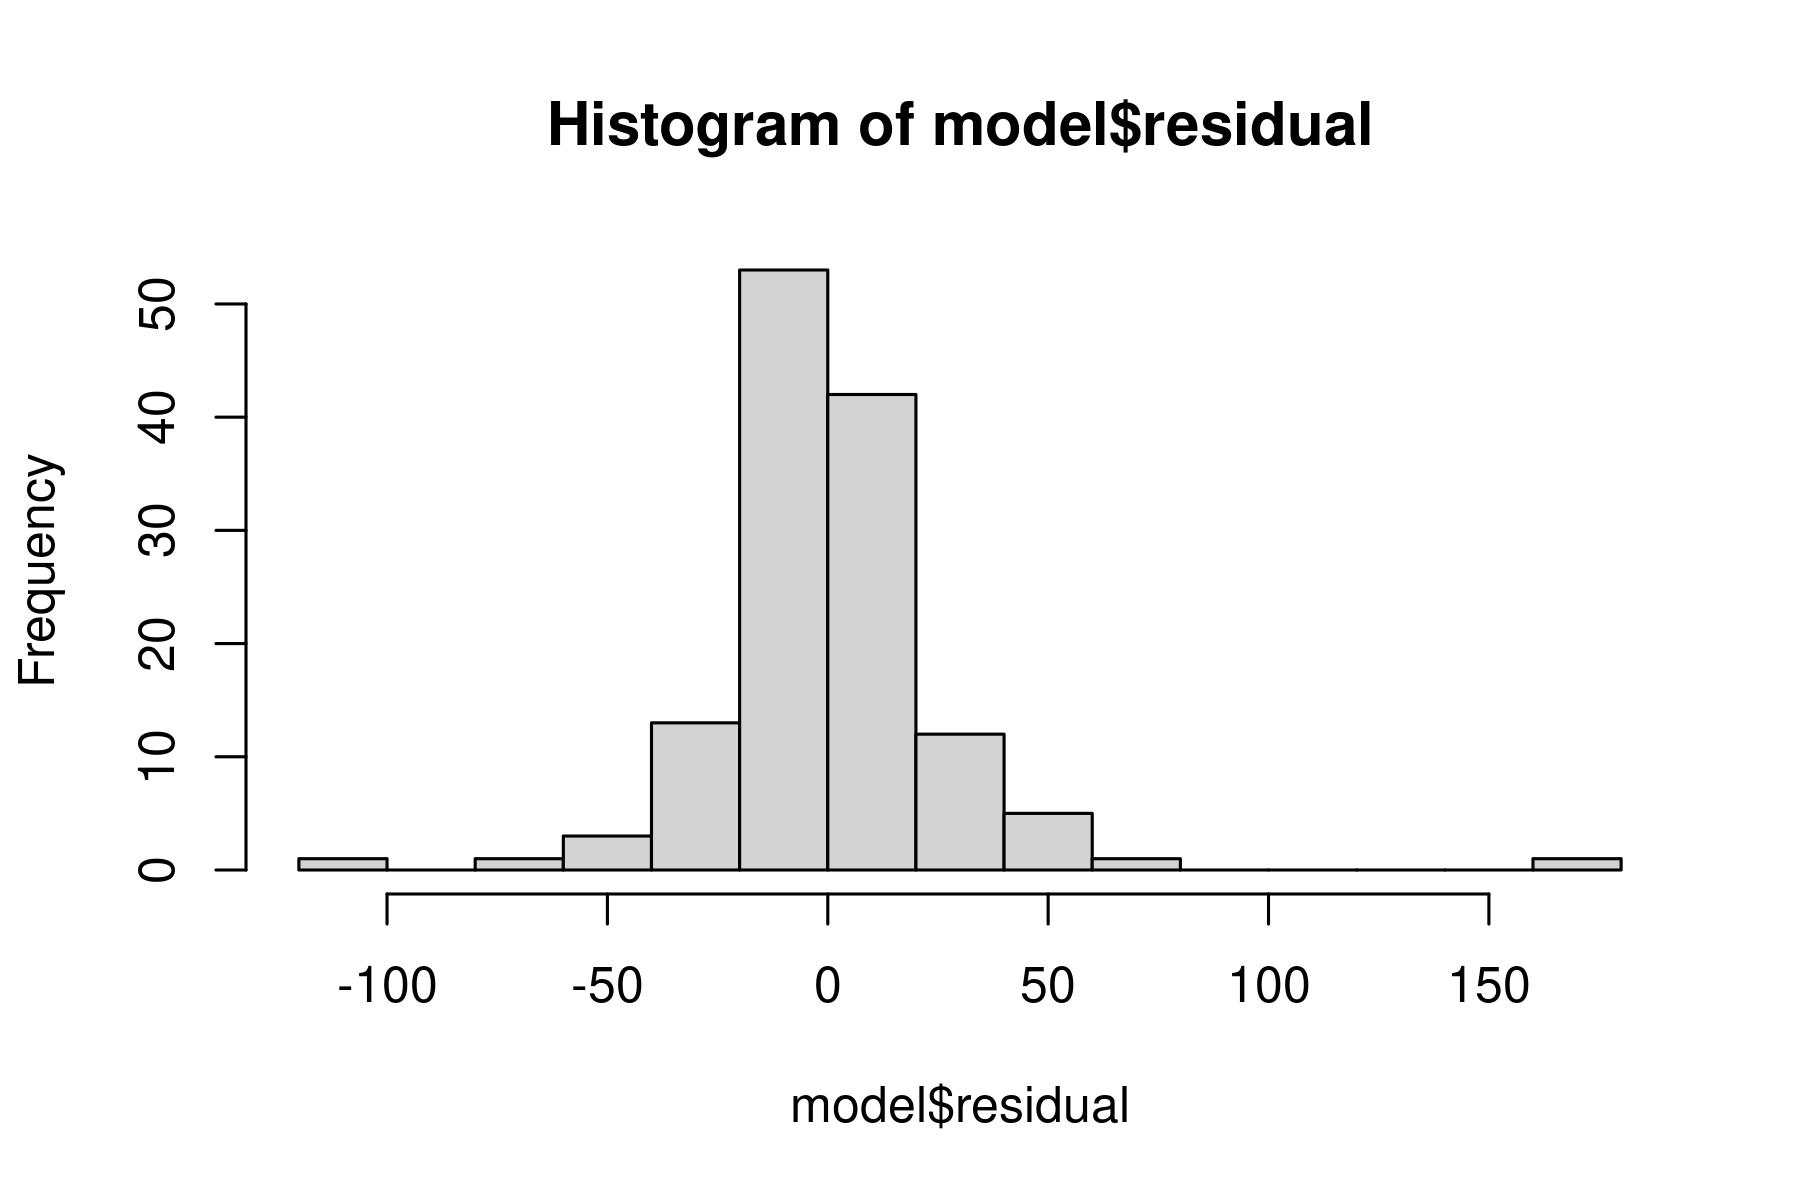

In [32]:
hist(model$residual,breaks=20)

[1] "Tenemos un elemento que tiene un residuo muy alto, ¿nos afectará a la predicción?"


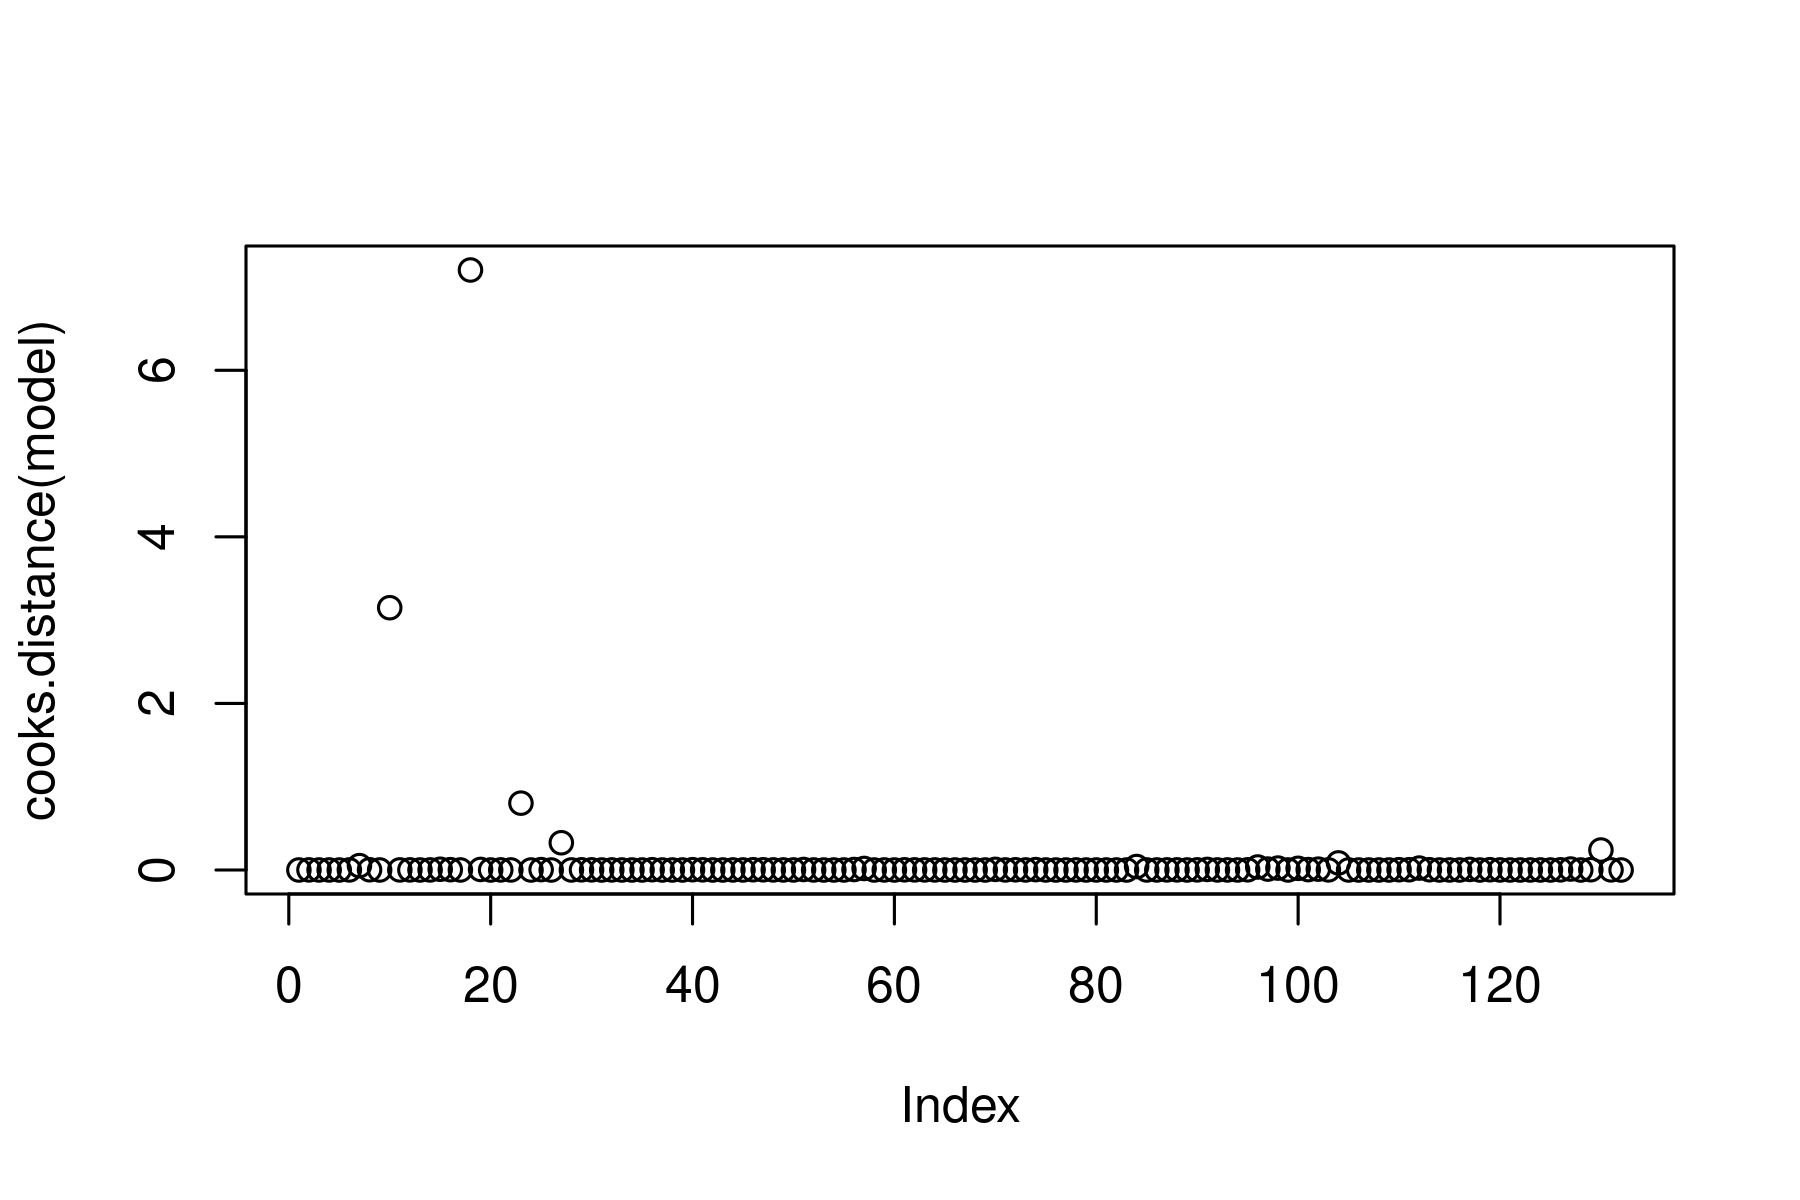

In [33]:
print("Tenemos un elemento que tiene un residuo muy alto, ¿nos afectará a la predicción?")
plot(cooks.distance(model))

In [34]:
cook_d<-cooks.distance(model)

df_madrid_id_train[names(cook_d),] %>% filter(cook_d>0.2)


Neighbourhood,Accommodates,Bathrooms,Bedrooms,Beds,Price,Guests.Included,Extra.People,Review.Scores.Rating,Latitude,Longitude,Square.Meters,neighb_id
<chr>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>
Jerónimos,4,2,1,2,95,2,15,91,40.41301,-3.689135,65.03210,neighd_id_3
Jerónimos,16,5,5,13,365,5,37,98,40.41826,-3.690208,480.02980,neighd_id_3
Rios Rosas,6,4,4,1,197,1,12,88,40.44153,-3.694571,200.02016,neighd_id_3
Justicia,6,1,2,6,500,4,15,93,40.42051,-3.699712,68.00500,neighd_id_1
Cortes,6,2,2,4,500,4,15,96,40.41364,-3.697923,74.97272,neighd_id_1


In [35]:
head(cook_d)

90           80           91           69           34          136 
0.0002262767 0.0012857403 0.0002937624 0.0005247579 0.0000377608 0.0009534887

In [68]:
# Aquí usamos como índice names(cook_d) porque los NAs no aparecen en la variable cook_d, 
# por eso los indices no tienen porque coincidir

model_cook<-lm(formula=Square.Meters~neighb_id+Price+Bedrooms, df_madrid_id_train[names(cook_d),] %>% filter(cook_d<0.2))

print("Comprobamos todas las medidas estadisticas en train y test para ver si tenemos overfitting:")


[1] "Comprobamos en el R² y otras medidas en train y test para ver si tenemos overfitting:"


No podemos filtrar por la distancia de cooks porque eliminamos un grupo entero de barrios y daría error.

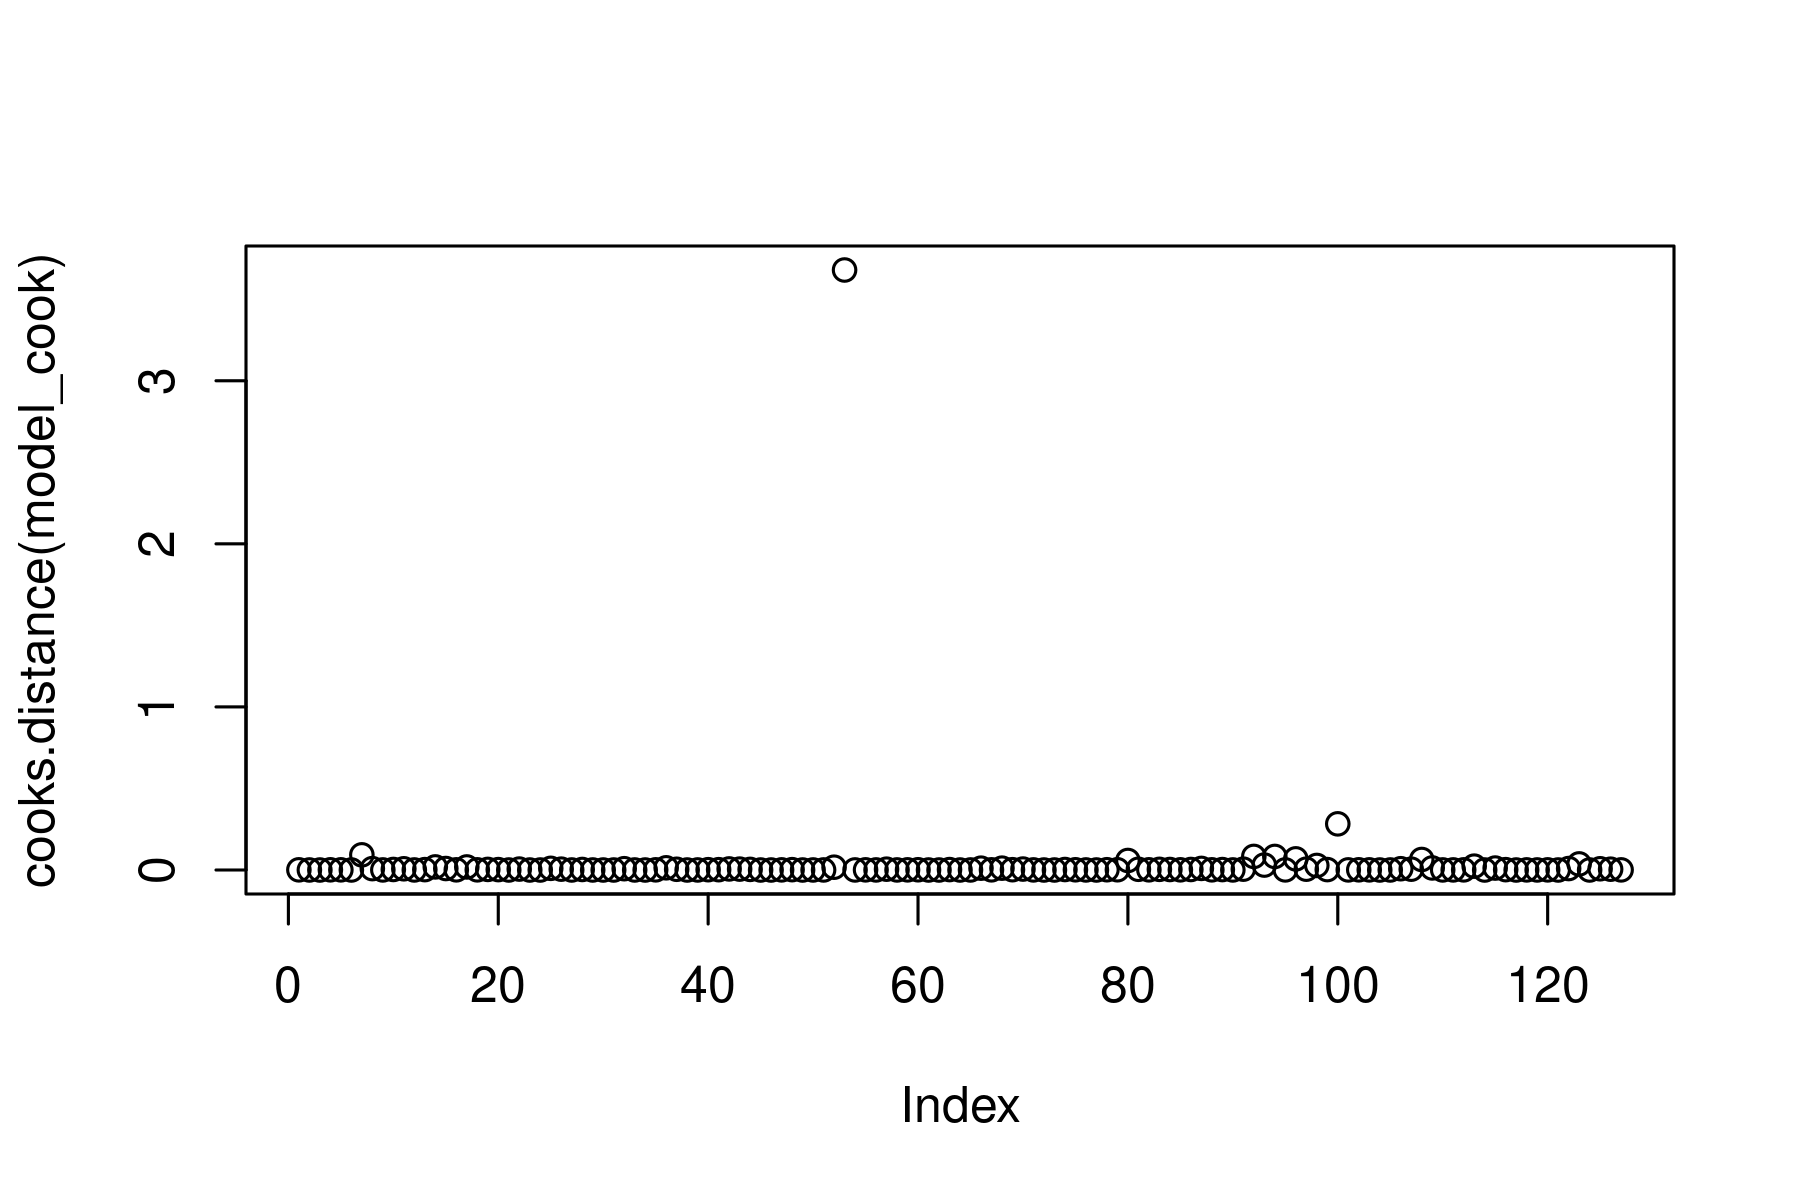

In [37]:
plot(cooks.distance(model_cook))

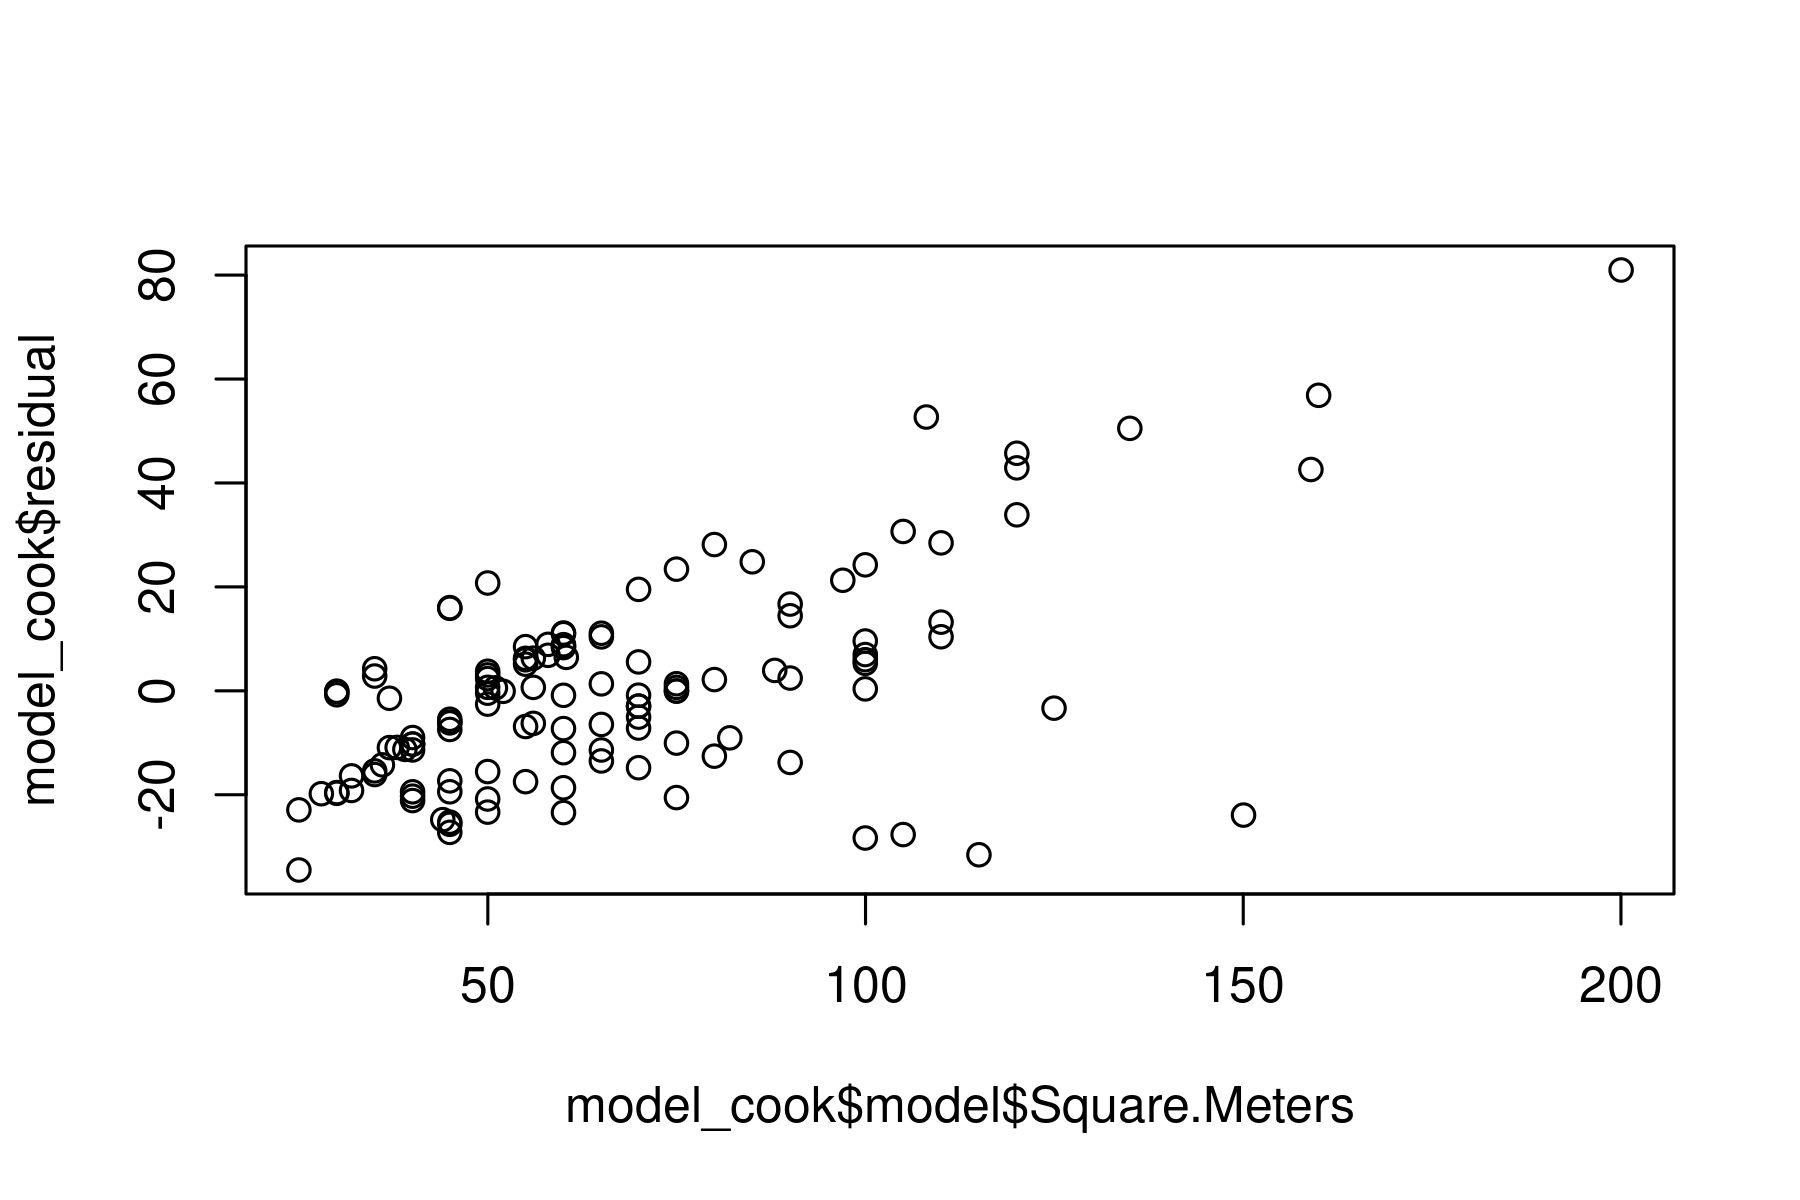

In [38]:
plot(model_cook$model$Square.Meters,model_cook$residual)

Vamos a probar con regularización por Ridge

In [39]:


### No he conseguido

library(glmnet)
over_fit_model<-lm(formula=Square.Meters~neighb_id+Bedrooms+Price*Accommodates, df_madrid_id)
X<-model.matrix(over_fit_model)
y<-as.matrix(over_fit_model$model$Square.Meters,ncols=1)
set.seed(12)
idx<-sample(1:nrow(X),nrow(X)*0.8)
X_train<-X[idx,]
X_test<-X[-idx,]
y_train<-y[idx,]
y_test<-y[-idx,]

cvfit<-cv.glmnet(X_train,y_train,nfolds=10,alpha=0)
cvfit$lambda.1se
cvfit$lambda.min
plot(cvfit)

ERROR: Error in library(package, pos = pos, lib.loc = lib.loc, character.only = TRUE, : there is no package called ‘glmnet’


In [40]:
## no lo he podido ver

gmodel<-glmnet(X,y,alpha=0,lambda = cvfit$lambda.1se)
caret::postResample(predict(gmodel,X_train),obs = y_train)
caret::postResample(predict(gmodel,X_test),obs = y_test)
plot(y_train,y_train-predict(gmodel,X_train))

ERROR: Error in glmnet(X, y, alpha = 0, lambda = cvfit$lambda.1se): no se pudo encontrar la función "glmnet"


In [41]:
## no lo he podido ver
gmodel<-glmnet(X,y,alpha=0,lambda = cvfit$lambda.min)
caret::postResample(predict(gmodel,X_train),obs = y_train)
caret::postResample(predict(gmodel,X_test),obs = y_test)
plot(y_train,y_train-predict(gmodel,X_train))
hist(y_train-predict(gmodel,X_train),breaks=20)

ERROR: Error in glmnet(X, y, alpha = 0, lambda = cvfit$lambda.min): no se pudo encontrar la función "glmnet"


Después de todas las pruebas concluimos que el mejor modelo era el primero, el más sencillo como veremos más adelante comprobando sus residuos. 

Aunque con tan pocas muestras es dificil saber cual es el mejor modelo. Una regla buena es que en igualdad de condiciones, el modelo más sencillo suele ser el más fiable (navaja de Ockham). 

Mirad el histograma de los residuos sobre el conjunto de test para evaluar la calidad de vuestro modelo

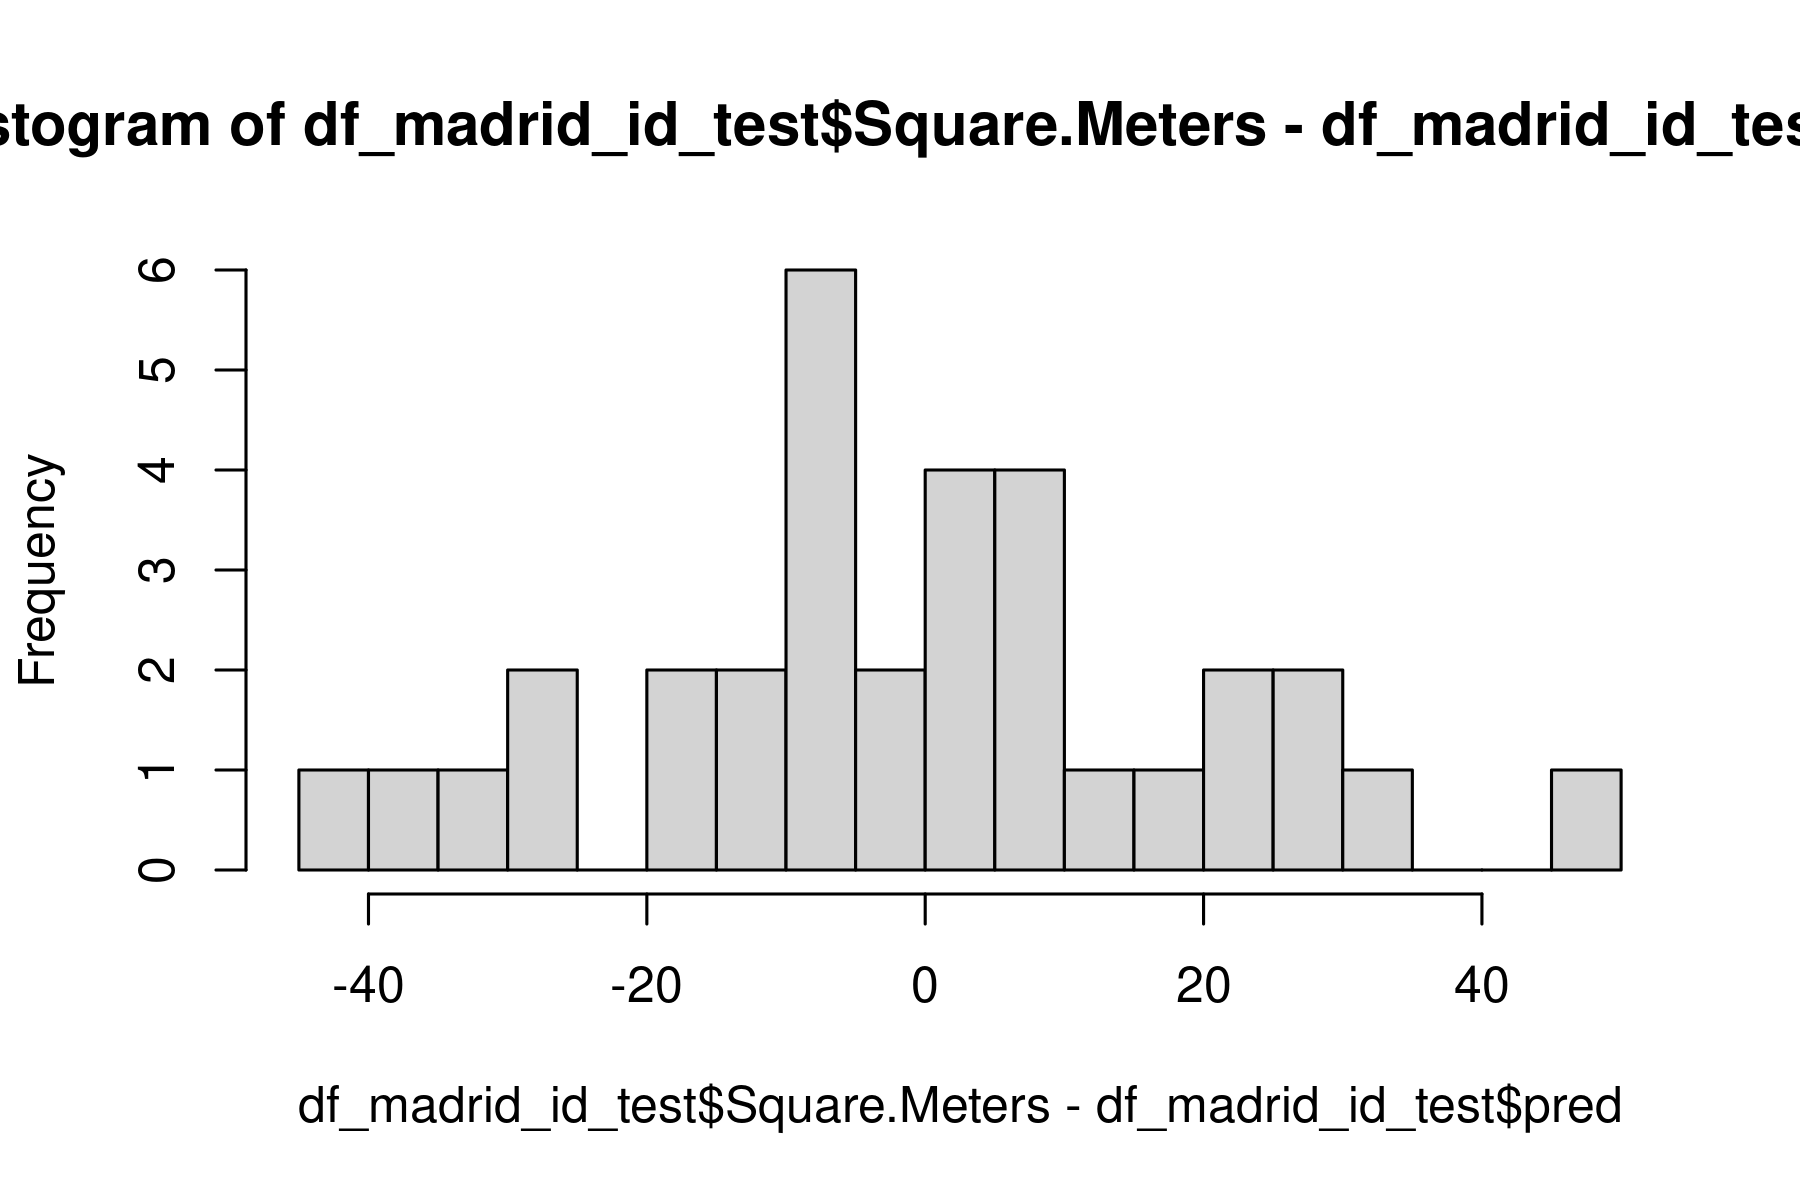

In [42]:
df_madrid_id_test$pred<-model %>% predict(df_madrid_id_test)
hist(df_madrid_id_test$Square.Meters-df_madrid_id_test$pred,breaks=15)


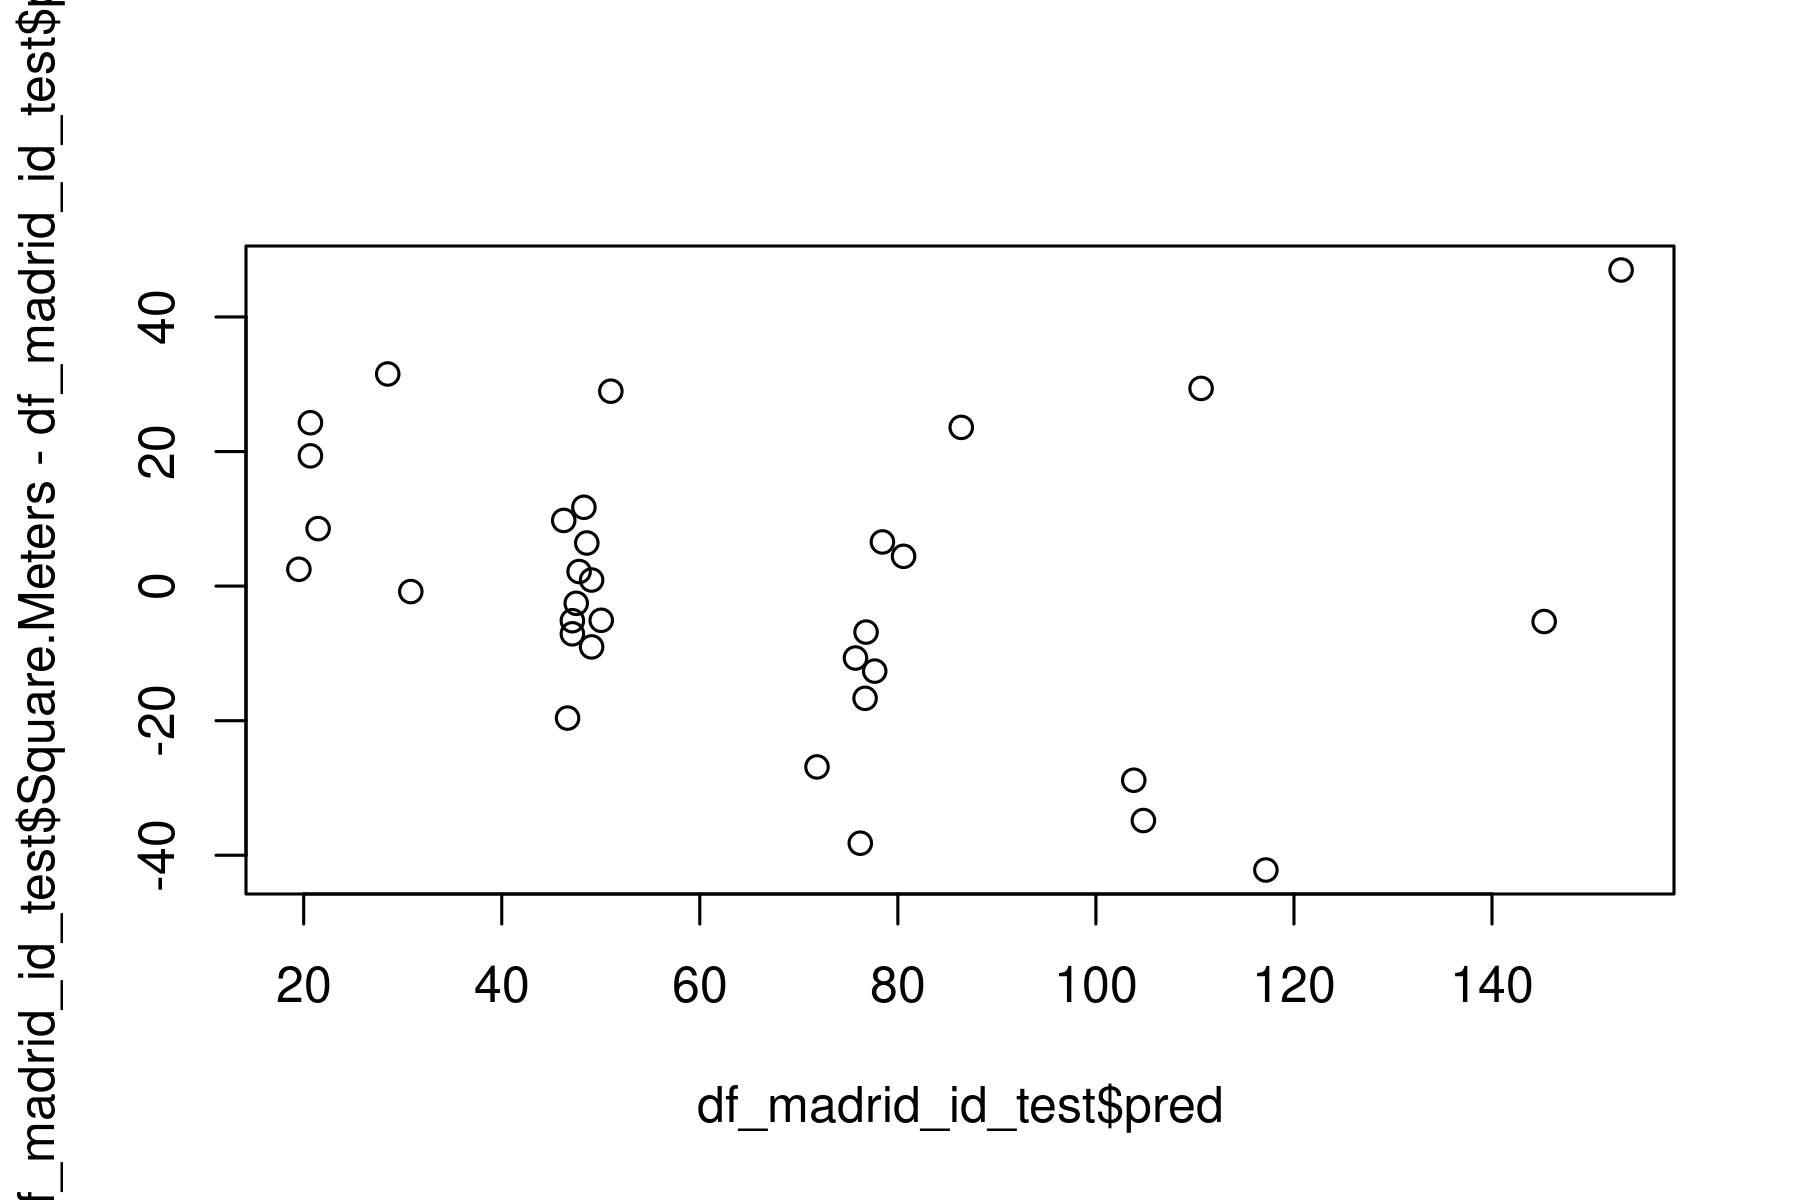

In [43]:
# Los residuos no siguen una distribución muy gaussiana, aunque con tan pocas muestras es dificil de verificarlo.
# Al menos su diagrama de dispersión si tiene buena pinta, no se ven tendencias:

plot(df_madrid_id_test$pred,df_madrid_id_test$Square.Meters-df_madrid_id_test$pred)

In [66]:
round(postResample(df_madrid_id_test$pred,obs = df_madrid_id_test$Square.Meters),4)

RMSE Rsquared      MAE 
   20.64     0.69    16.05

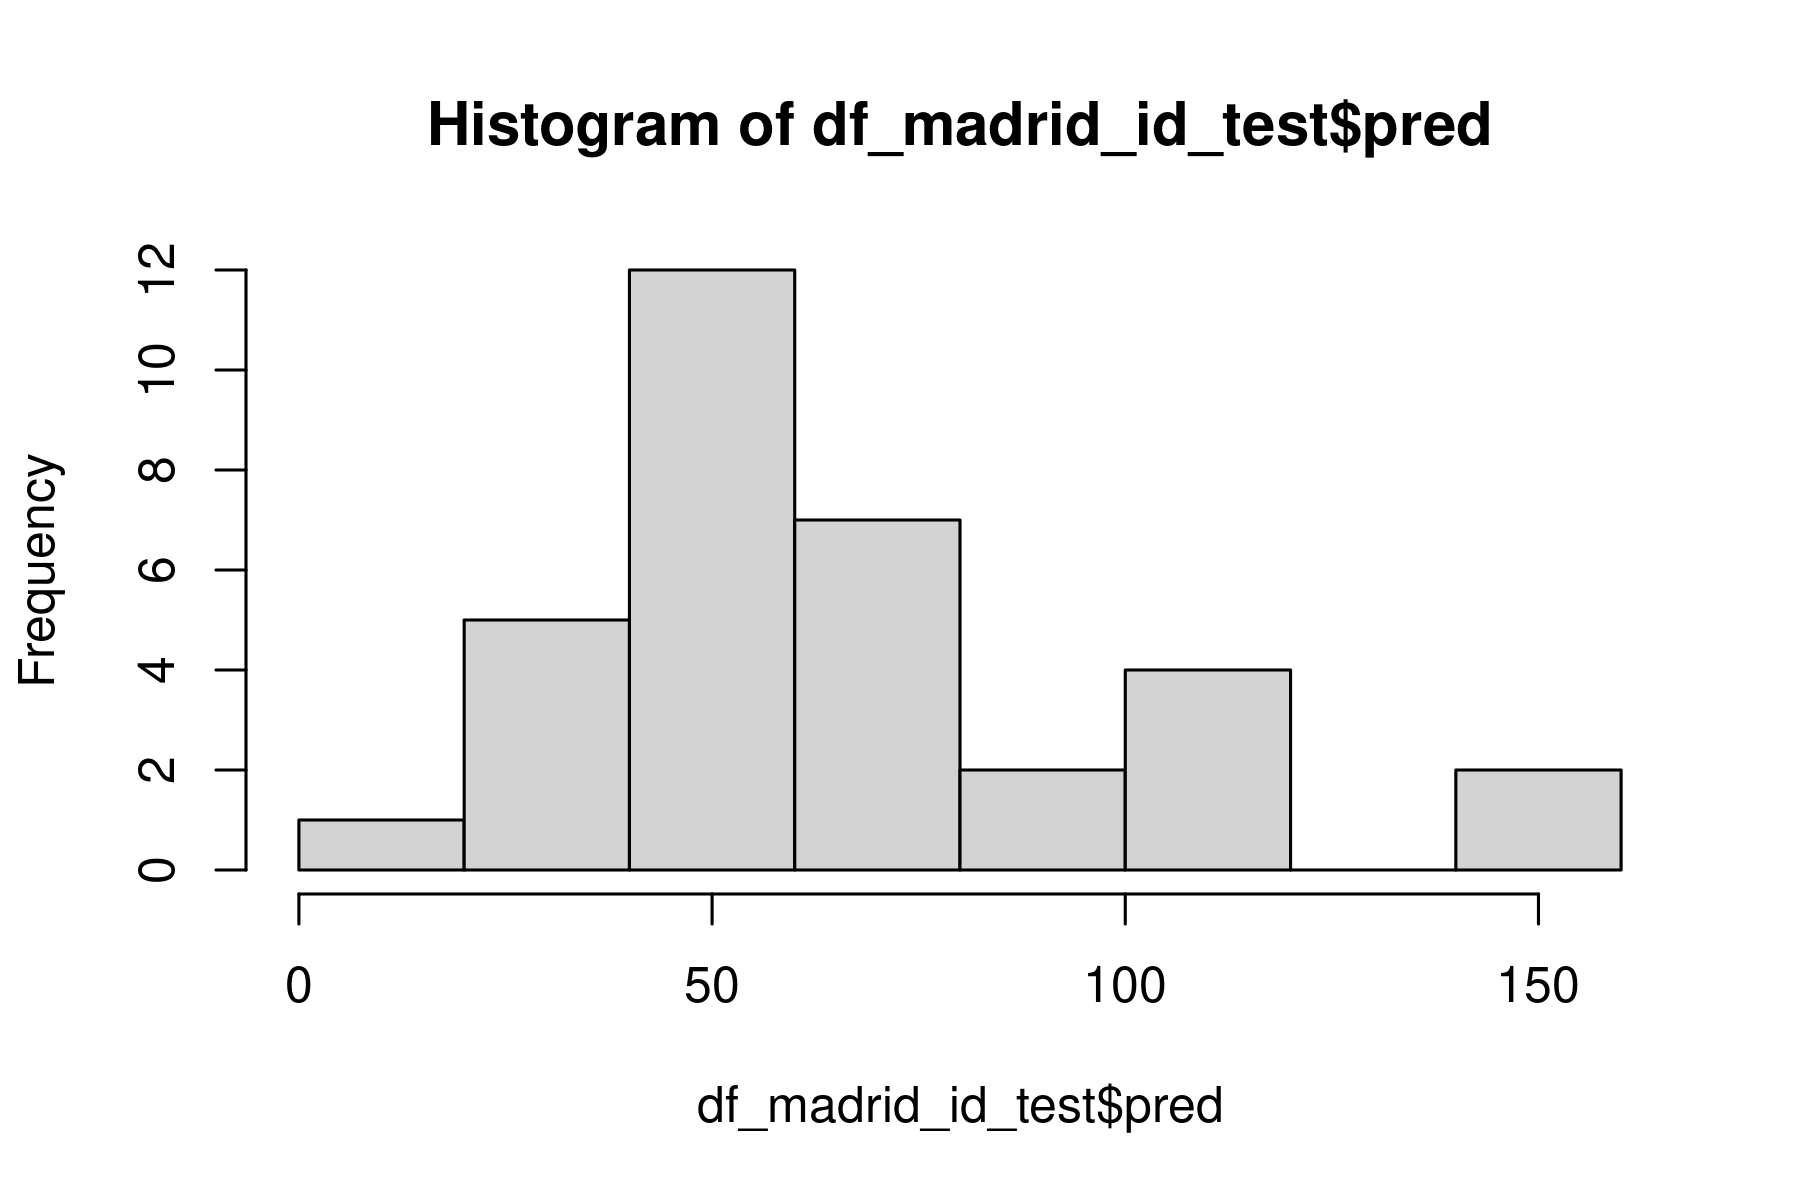

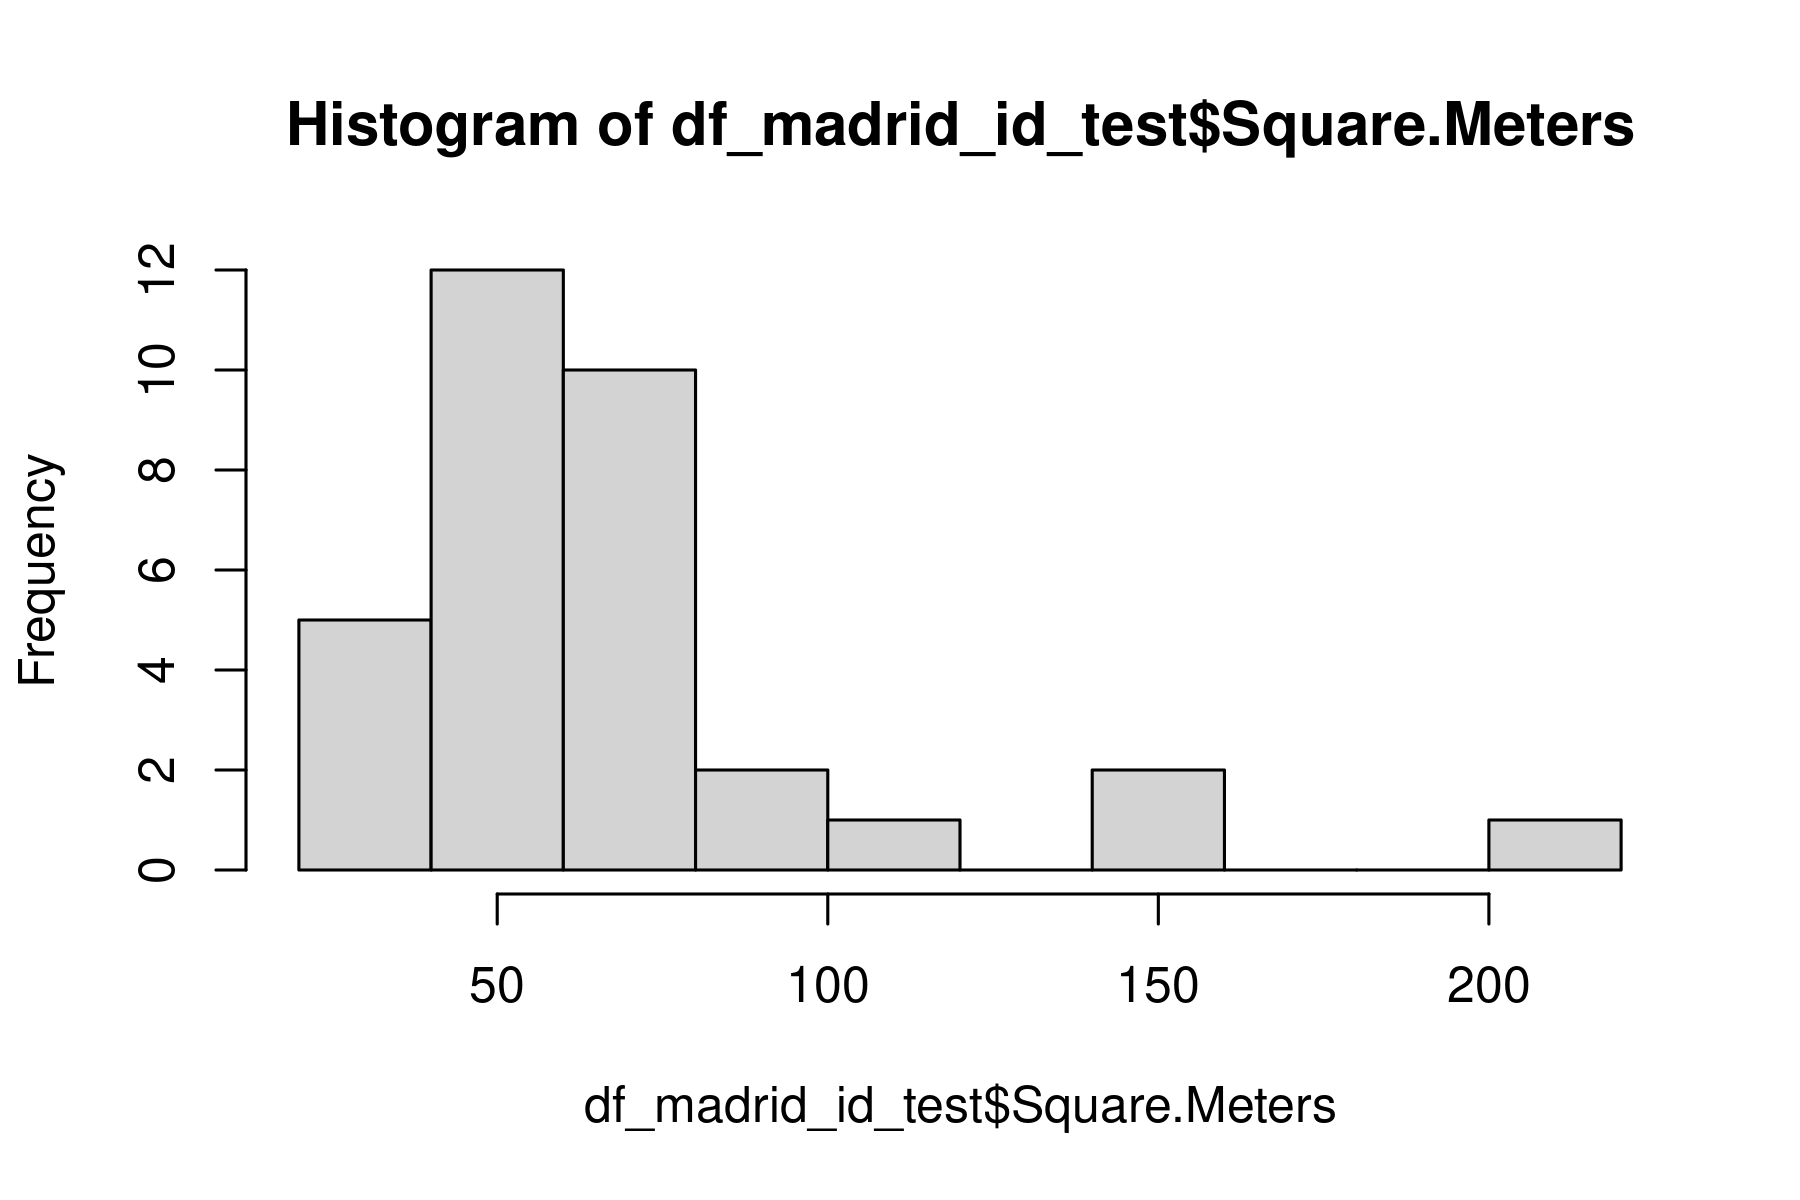

In [48]:
hist(df_madrid_id_test$pred)
hist(df_madrid_id_test$Square.Meters)

Si tuvieramos un anuncio de un apartamento para 6 personas (Accommodates), con 1 baño, con un precio de 80€/noche y 3 habitaciones en el barrio de Sol, con 3 camas y un review de 80.
¿Cuantos metros cuadrados tendría? Si tu modelo necesita algúna variable adicional puedes inventartela dentro del rango de valores del dataset.
¿Como varía sus metros cuadrados con cada habitación adicional?

In [49]:
# Buscamos el neighb_id del barrio de Sol:
neighb_id_sol<-df_barrios %>% filter(names=="Sol") %>% select(neighb_id)
paste0("El id de barrio es:",neighb_id_sol)

# Creamos el dataframe:
df_appartment<-data.frame(neighb_id=neighb_id_sol,Bedrooms=3,Price=80,Accommodates=6)

# Predicción
pred_m2<-predict(model,df_appartment)
paste("Los metros que tiene son:",round(pred_m2))

[1] "El id de barrio es:neighd_id_2"

[1] "Los metros cuadrados son: 110"

In [50]:
cf<-coefficients(model)
cf_bedroom_sol<-cf['Bedrooms']

paste("En media cada habitación aumenta el tamaño del apartemos en:",round(cf_bedroom_sol,2),"m^2")


[1] "En media cada habitación aumenta el tamaño del apartemos en: 26.16 m^2"

Rellenar los Square.Meters con valor NA con el estimado con el modelo anterior.

In [51]:
df_madrid_id_all <- df_madrid %>% inner_join(df_barrios,by=c("Neighbourhood"='names')) 

df_madrid_id_all$Square.Meters[is.na(df_madrid_id_all$Square.Meters)]<-
 round(predict(model,df_madrid_id_all[is.na(df_madrid_id_all$Square.Meters),]))

head(df_madrid_id_all)

,Neighbourhood,Accommodates,Bathrooms,Bedrooms,Beds,Price,Guests.Included,Extra.People,Review.Scores.Rating,Latitude,Longitude,Square.Meters,neighb_id
,<chr>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>
1,La Latina,6,2.0,2,2,72,2,20,90,40.41206,-3.709149,54.99858,neighd_id_1
2,Acacias,4,1.0,1,2,60,2,15,98,40.40513,-3.707726,49.98181,neighd_id_1
3,Malasaña,4,1.0,2,3,105,1,0,97,40.42900,-3.703498,69.95596,neighd_id_1
4,Recoletos,2,1.0,0,2,61,1,0,92,40.42800,-3.686409,30.00767,neighd_id_1
5,Malasaña,8,2.0,3,4,120,6,0,83,40.42198,-3.705419,109.99715,neighd_id_1
6,Argüelles,4,1.5,2,2,95,2,15,89,40.42920,-3.717775,96.99073,neighd_id_1


Usar PCA para encontrar el apartamento más cercano a uno dado.

Este algoritmo nos ayudaría a dado un apartamento que el algoritmo nos devolvería los 5 apartamentos más similares.


Crearemos una función tal que le pasemos un apartamento con los siguientes datos:
* Accommodates	
* Bathrooms	
* Bedrooms	
* Beds	
* Price	
* Guests.Included	
* Extra.People	
* Review.Scores.Rating	
* Latitude	
* Longitude	
* Square.Meters

y nos devuelva los 5 más similares de:

In [52]:
##Data frame para el PCA

df_madrid_pca<-na.omit(df_madrid_id_all[,c("Accommodates","Bathrooms","Bedrooms","Latitude","Longitude",
                                           "Beds","Price","Review.Scores.Rating","Square.Meters",'neighb_id')])


pca_df<-prcomp(df_madrid_pca %>% select(-neighb_id),center = TRUE, scale. = TRUE)

In [53]:
summary(df_madrid_pca)

  Accommodates      Bathrooms        Bedrooms        Latitude    
 Min.   : 2.000   Min.   :1.000   Min.   :0.000   Min.   :40.38  
 1st Qu.: 3.000   1st Qu.:1.000   1st Qu.:1.000   1st Qu.:40.41  
 Median : 4.000   Median :1.000   Median :1.000   Median :40.42  
 Mean   : 4.491   Mean   :1.288   Mean   :1.576   Mean   :40.42  
 3rd Qu.: 6.000   3rd Qu.:1.000   3rd Qu.:2.000   3rd Qu.:40.43  
 Max.   :16.000   Max.   :5.000   Max.   :5.000   Max.   :40.48  
   Longitude           Beds            Price       Review.Scores.Rating
 Min.   :-3.732   Min.   : 1.000   Min.   : 30.0   Min.   : 50.00      
 1st Qu.:-3.707   1st Qu.: 1.000   1st Qu.: 60.0   1st Qu.: 88.00      
 Median :-3.703   Median : 2.000   Median : 75.0   Median : 93.00      
 Mean   :-3.698   Mean   : 2.679   Mean   : 93.3   Mean   : 90.44      
 3rd Qu.:-3.698   3rd Qu.: 3.000   3rd Qu.:100.0   3rd Qu.: 95.00      
 Max.   :-3.576   Max.   :13.000   Max.   :500.0   Max.   :100.00      
 Square.Meters     neighb_id      

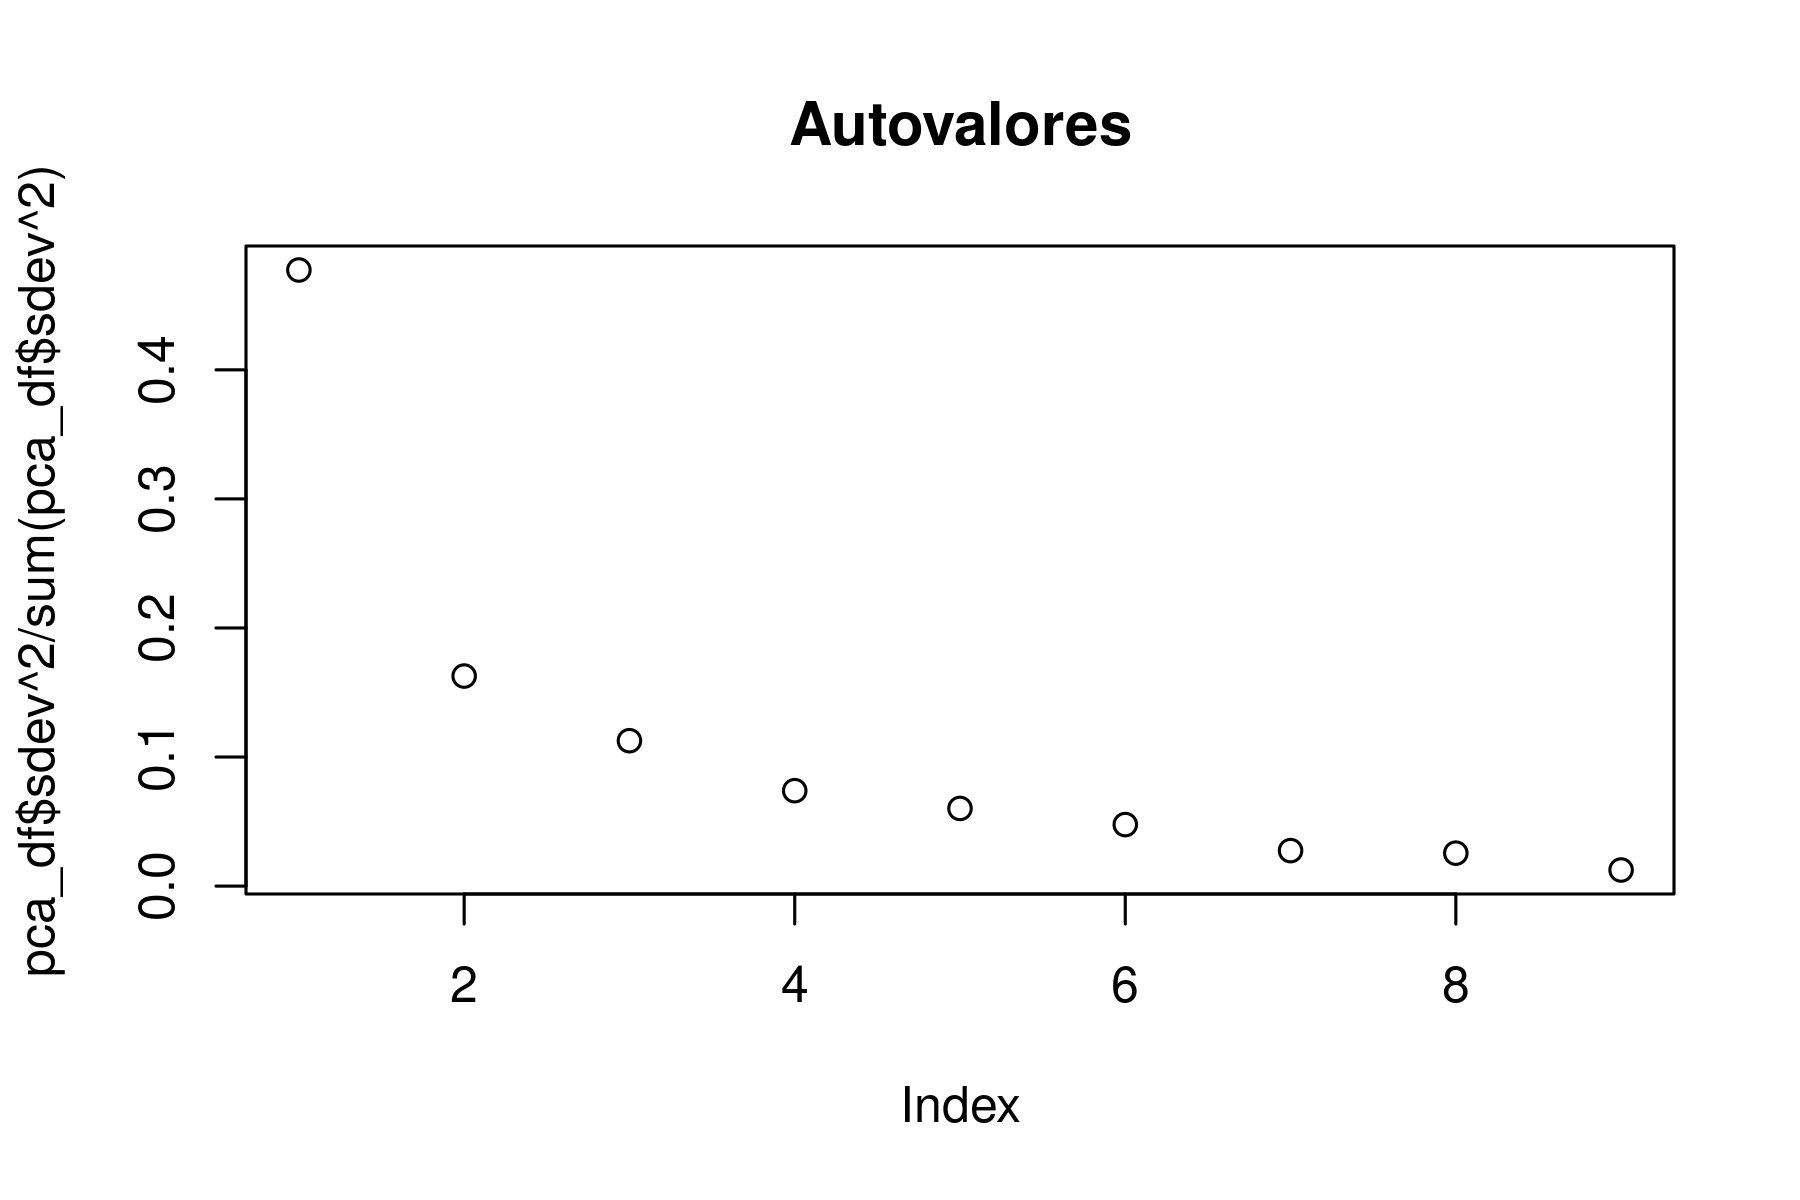

In [54]:
plot(pca_df$sdev^2/sum(pca_df$sdev^2),main="Autovalores")

In [55]:
str(pca_df)

List of 5
 $ sdev    : num [1:9] 2.073 1.21 1.007 0.816 0.736 ...
 $ rotation: num [1:9, 1:9] -0.4336 -0.3993 -0.4223 -0.021 -0.0508 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:9] "Accommodates" "Bathrooms" "Bedrooms" "Latitude" ...
  .. ..$ : chr [1:9] "PC1" "PC2" "PC3" "PC4" ...
 $ center  : Named num [1:9] 4.49 1.29 1.58 40.42 -3.7 ...
  ..- attr(*, "names")= chr [1:9] "Accommodates" "Bathrooms" "Bedrooms" "Latitude" ...
 $ scale   : Named num [1:9] 2.1058 0.6127 0.9948 0.0164 0.0203 ...
  ..- attr(*, "names")= chr [1:9] "Accommodates" "Bathrooms" "Bedrooms" "Latitude" ...
 $ x       : num [1:165, 1:9] -0.5228 1.0242 -0.0561 1.9902 -2.5208 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:165] "1" "2" "3" "4" ...
  .. ..$ : chr [1:9] "PC1" "PC2" "PC3" "PC4" ...
 - attr(*, "class")= chr "prcomp"


In [56]:
get_closest_element<-function(pca_df, new_flat,num_flats){
    pca_new<-predict(pca_df,newdata = new_vector)
    pca_orig<-pca_df$x[,1:2]
    pca_new <-pca_new[,1:2]

    idx<-order(rowSums((pca_new-pca_orig)^2))
    df_madrid_pca[idx %in% 1:num_flats,]
}

In [57]:
new_vector<-(df_madrid_pca %>% select(-neighb_id))[10,]
new_vector
get_closest_element(pca_df,new_vector,5)

,Accommodates,Bathrooms,Bedrooms,Latitude,Longitude,Beds,Price,Review.Scores.Rating,Square.Meters
,<int>,<dbl>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>
10,9,2,4,40.4303,-3.671762,8,120,91,99.96363


,Accommodates,Bathrooms,Bedrooms,Latitude,Longitude,Beds,Price,Review.Scores.Rating,Square.Meters,neighb_id
,<int>,<dbl>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<chr>
11,5,1,1,40.39268,-3.712169,3,32,81,54.99858,neighd_id_1
35,4,1,0,40.47221,-3.693440,1,52,72,44.96505,neighd_id_1
43,5,1,1,40.42721,-3.708675,1,75,90,49.98181,neighd_id_1
52,5,1,2,40.41609,-3.706012,5,100,91,69.95596,neighd_id_2
141,6,1,2,40.42051,-3.699712,6,500,93,68.00500,neighd_id_1


Bonus: ¿de todas las coordenadas PCA cual es la que mejor permite clasificar por id de barrio?

¿Por qué?

##### Forma 1

In [62]:
#  ANOVA de cada componente principal (PC) por neighb_id

pca_x_neighb<-cbind(data.frame(pca_df$x),neighb_id=df_madrid_pca$neighb_id)
pca_cols<-colnames(pca_x_neighb)[1:ncol(pca_x_neighb)-1]
df_F_val<-data.frame(pca=pca_cols,F=NA)

for (idx in (1:nrow(df_F_val))){
    formula<-paste(pca_cols[idx],"~ neighb_id")
    df_F_val$F[idx]<-oneway.test(pca_x_neighb,formula = as.formula(formula))$statistic
}

df_F_val

pca,F
<chr>,<dbl>
PC1,4.43981021
PC2,2.07009854
PC3,5.70454733
PC4,0.98549669
PC5,1.18361792
PC6,6.16183898
PC7,0.27206424
PC8,0.07925337
PC9,0.30530797


Parece que PC6 y PC9 son los que más varían a la hora de elegir por id de barrio. Vamos a analizar porqué.

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


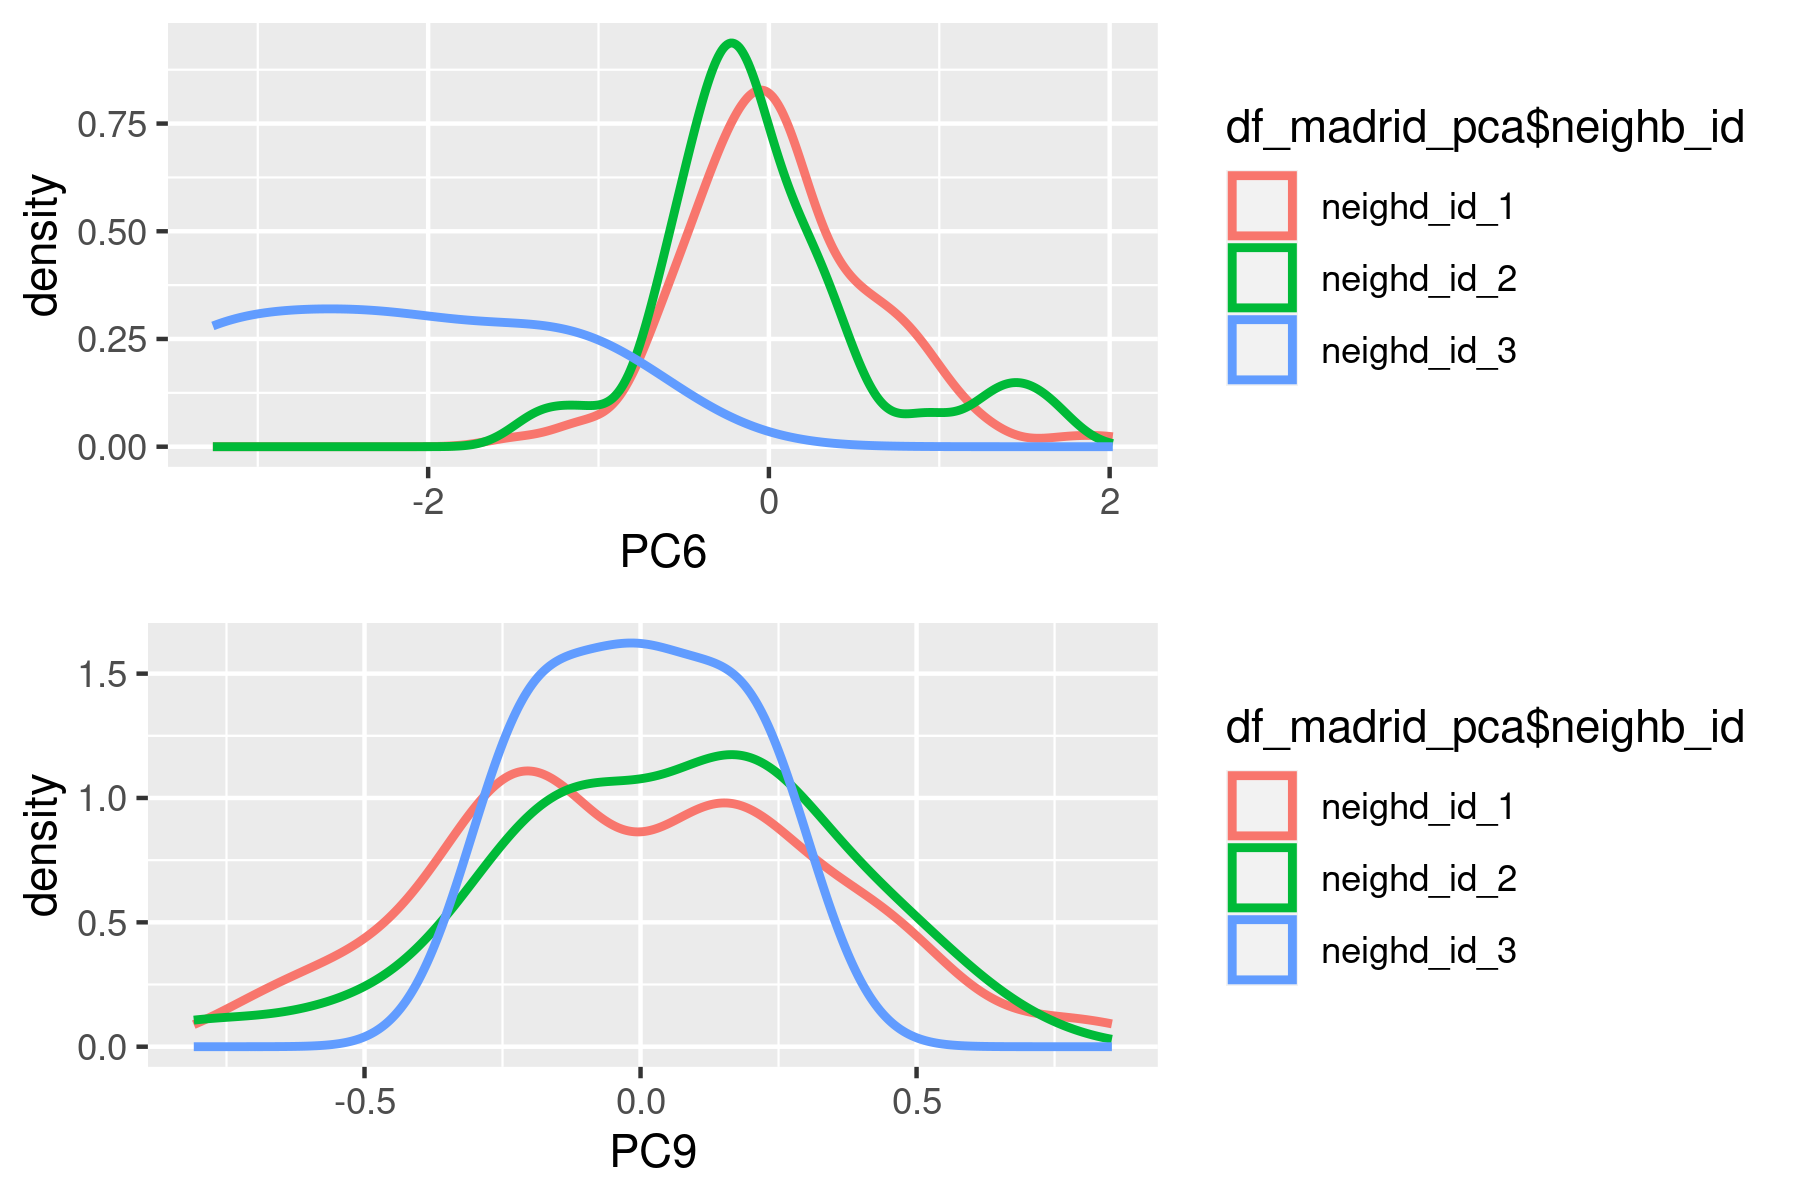

In [63]:
library(ggpubr)

g1<-ggplot(data.frame(pca_df$x),aes(x=PC6,color=df_madrid_pca$neighb_id))+geom_density(size=1)
g2<-ggplot(data.frame(pca_df$x),aes(x=PC9,color=df_madrid_pca$neighb_id))+geom_density(size=1)

ggarrange(g1,g2,ncol=1)

In [64]:
pca_df$rotation
# Vemos como la contribución principal a PC6 y PC9 son los metros cuadrados 
# o medidas relacionadas con los mismos como el número de habitaciones.
# Lo cual es lógico porque hemos clusterizado utilizando los metros cuadrados.

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
Accommodates,-0.43355181,0.06570671,-0.20358120,0.067836202,-0.22608827,0.28374037,-0.23664202,0.06764097,0.754631802
Bathrooms,-0.39927373,-0.16256255,0.02140517,-0.156763749,-0.17285642,-0.59531557,-0.28249300,0.54693690,-0.160930466
Bedrooms,-0.42226100,0.04674594,0.02620515,0.250473400,-0.07790952,0.09491141,0.81843103,0.25217727,-0.087097845
Latitude,-0.02103995,-0.69044997,0.07433111,-0.530590242,-0.30242657,0.35013193,0.12590320,-0.04357721,-0.063089238
Longitude,-0.05078985,-0.65265431,0.19907175,0.614621526,0.35330060,-0.03339252,-0.12777401,-0.02206015,0.106415878
Beds,-0.42073504,0.10100032,-0.14385563,0.198229674,-0.05033492,0.47586917,-0.37705740,-0.08732028,-0.611563027
Price,-0.33802343,0.06384848,0.09236177,-0.454562787,0.80562567,0.10347578,0.01916301,0.03640863,0.071223215
Review.Scores.Rating,-0.04974275,0.22239470,0.93494335,0.003467896,-0.16856626,0.15673311,-0.11830573,0.06557968,0.051559474
Square.Meters,-0.42134846,-0.02559216,0.09439770,-0.053539421,-0.12911552,-0.41309949,0.07520210,-0.78552824,0.001068155


##### Forma 2

Otra forma de obtener lo mismo con LDA

In [65]:
MASS::lda(formula=neighb_id~.,data=pca_x_neighb)

Call:
lda(neighb_id ~ ., data = pca_x_neighb)

Prior probabilities of groups:
neighd_id_1 neighd_id_2 neighd_id_3 
 0.77575758  0.20606061  0.01818182 

Group means:
                   PC1         PC2        PC3          PC4         PC5
neighd_id_1  0.3719169 -0.04977409  0.0286906 -0.006468227 -0.01373686
neighd_id_2 -0.8704090  0.23618022 -0.1374338  0.080636208  0.08732457
neighd_id_3 -6.0038182 -0.55301484  0.3334509 -0.637899356 -0.40357241
                    PC6         PC7         PC8          PC9
neighd_id_1  0.06151509  0.02188591  0.01331539 -0.010759199
neighd_id_2 -0.03639798 -0.04820906 -0.01647785  0.040732574
neighd_id_3 -2.21213343 -0.38742936 -0.38137442 -0.002576694

Coefficients of linear discriminants:
            LD1         LD2
PC1 -0.43380352  0.24061613
PC2 -0.05047809 -0.40512844
PC3  0.04548673  0.34221953
PC4 -0.21722605 -0.40128210
PC5 -0.14813509 -0.45785128
PC6 -1.39579980 -0.55470774
PC7 -0.47605302  0.19955274
PC8 -0.46306636 -0.08191537
PC9  0.10593758

Si nos fijamos en los coeficiente, en "Proportion of trace" vemos que con los dos primeros componentes LD1 y LD2 son los más importantes para clasificar por neighb_id.
Y si miramos los coeficientes que más importancia tienen en LD1 y LD2 son a su vez PC2 y PC9 como habíamos visto antes con el test ANOVA.